In [1]:
# Install the snowdroughtindex package
#%pip install git+https://github.com/Nadiesenali/snowdroughtindex-main

# Install required packages
#%pip install numpy pandas xarray geopandas matplotlib shapely scipy scikit-learn 

# Import required packages
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from numpy import trapz
from scipy.stats import gamma, norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import matplotlib.patches as mpatches
import sys
from pathlib import Path
import logging

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Import snowdroughtindex package
from snowdroughtindex.core import sswei

# Configuration

In [2]:
# Configuration
config = {
    'casr_input_dir': project_root / 'data' / 'output_data' / 'merged_2d' / '1980_2024' / 'bow_combined_full_data.csv',
    'SnoDRI_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison' / 'SnoDRI_final.csv',
    'shapefile_dir': project_root / 'data' / 'input_data' / 'shapefiles' / 'BowRiverBasin' / 'Bow_elevation_combined.shp',
    'output_dir': project_root / 'data' / 'output_data' / '1980_2024' / 'comparison',
    'plots': project_root / 'data' / 'output_plots' / '1980_2024' / 'comparison',
}

# Create output directories
config['output_dir'].mkdir(parents=True, exist_ok=True)
config['plots'].mkdir(parents=True, exist_ok=True)

print("Configuration set")
print(f"Output directory: {config['output_dir']}")

Configuration set
Output directory: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison


# Select data for analysis

In [3]:
# Load CSV, detect datetime column, select winter season (Oct-May next year) for seasons starting 1980-2023
df = pd.read_csv(config['casr_input_dir'])

# detect a datetime-like column (common names first), otherwise try to infer
possible_names = ['date', 'datetime', 'time', 'timestamp', 'Date', 'DATE']
datetime_col = None
for name in possible_names:
    if name in df.columns:
        datetime_col = name
        break

if datetime_col is None:
    # try to find any column that parses to datetimes for majority of rows
    for col in df.columns:
        parsed = pd.to_datetime(df[col], errors='coerce')
        if parsed.notna().sum() >= 0.6 * len(df):
            datetime_col = col
            break

if datetime_col is None:
    # fallback: try the first column
    datetime_col = df.columns[0]

# create a standardized date column
df['date'] = pd.to_datetime(df[datetime_col], errors='coerce')
n_missing_dates = df['date'].isna().sum()
if n_missing_dates:
    logger.warning("Found %d rows with unparseable dates in column '%s' and they will be dropped.", n_missing_dates, datetime_col)
df = df.dropna(subset=['date']).reset_index(drop=True)

# add month/year and season_year (season starts in Oct and is labeled by its starting year)
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['season_year'] = np.where(df['month'] >= 10, df['year'], df['year'] - 1)

# filter to months Oct(10) through May(5) and seasons starting between 1980 and 2023 inclusive
winter_months = [10, 11, 12, 1, 2, 3, 4, 5]
winter_df = df[df['month'].isin(winter_months) & df['season_year'].between(1980, 2023)].copy()

# optional: set date as index
winter_df = winter_df.set_index('date')

print(f"Original rows: {len(df)}; Winter rows (1980-2023 seasons): {len(winter_df)}")
winter_df.head()

Original rows: 4224309; Winter rows (1980-2023 seasons): 2750671


Grid_id        time       lon      lat         SWE  Precipitation  \
date                                                                            
1980-10-10        1  1980-10-10 -116.1380  51.3346    0.878418       0.009879   
1983-10-12        2  1983-10-12 -116.1875  51.4191    6.875000       0.023846   
1980-12-11        2  1980-12-11 -116.1875  51.4191  118.125000       4.578907   
1982-10-29        2  1982-10-29 -116.1875  51.4191   23.125000       1.777088   
1982-01-18        2  1982-01-18 -116.1875  51.4191  145.000000       1.890419   

            Mean_Temp   Max_Temp  Humidity        Flux  Surface_Pressure  \
date                                                                       
1980-10-10  -3.783902   6.402542  0.002236  127.042317        792.259058   
1983-10-12  -3.537311   8.740372  0.002839  139.681642        793.773767   
1980-12-11  -7.179487  -2.481613  0.002436   19.707682        778.646749   
1982-10-29  -8.325263  -1.888809  0.002016  107.054688        774.911829   
1982-01-18 -16.744781 -13.240707  0.001073   46.103516        765.437045   

               Vwind Elevation_Category  month  year  season_year  
date                                                               
1980-10-10  0.311295         2000_2500m     10  1980         1980  
1983-10-12 -0.336093         2000_2500m     10  1983         1983  
1980-12-11  0.921281         2000_2500m     12  1980         1980  
1982-10-29 -0.176696         2000_2500m     10  1982         1982  
1982-01-18 -0.148752         2000_2500m      1  1982         1981

In [4]:
# save the filtered winter data to a CSV file
output_file_winter = config['output_dir'] / 'bow_casr_winter_data.csv'
winter_df.to_csv(output_file_winter, index=True)
print(f"Winter data saved to {output_file_winter}")

Winter data saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\bow_casr_winter_data.csv


Saved figure to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\swe_by_elevation_each_year_timeseries.png


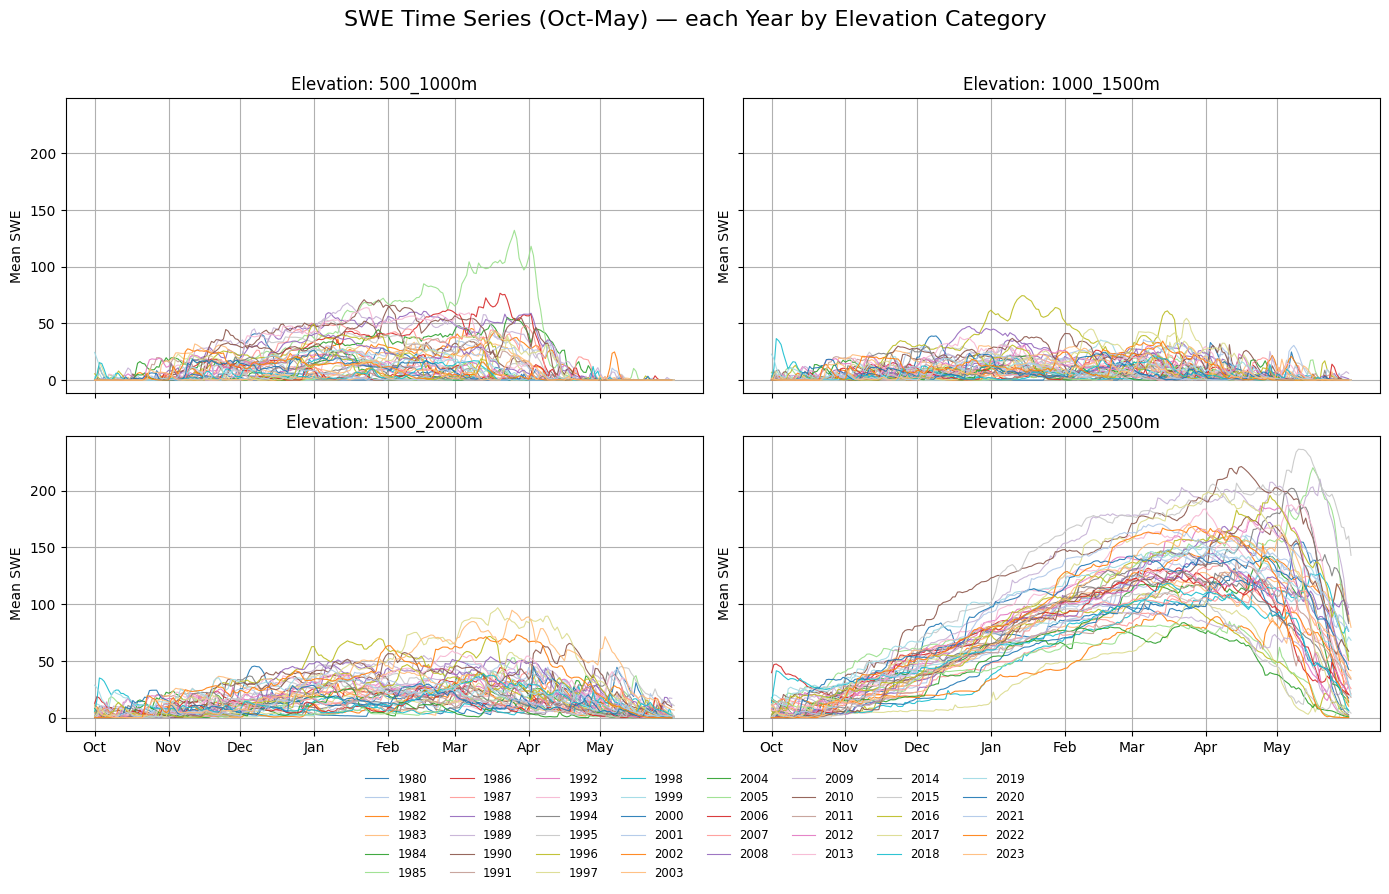

In [5]:
# Plot SWE for each season_year (Oct-May) per elevation category (up to 4 categories)
df_plot = winter_df.reset_index()  # date is a column here
cats_all = df_plot['Elevation_Category'].astype(str).unique()
cats = sorted(cats_all)[:4]  # up to 4 categories

# compute season start and season_day (days since Oct 1 of season_year)
df_plot['season_start'] = pd.to_datetime(df_plot['season_year'].astype(str) + '-10-01')
df_plot['season_day'] = (df_plot['date'] - df_plot['season_start']).dt.days

# aggregate: mean SWE across grid points for each Elevation_Category, season_year and season_day
swe_by_day = df_plot.groupby(['Elevation_Category', 'season_year', 'season_day'])['SWE'].mean()

# arrange categories in the requested order (keep only those present)
desired_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
cats = [c for c in desired_order if c in list(cats_all)]

# fallback to previous selection if none of the desired categories are found
if not cats:
    cats = sorted(cats_all)[:4]

# ensure plot dir exists
config['plots'].mkdir(parents=True, exist_ok=True)

# create subplots
n = len(cats)
ncols = 2
nrows = (n + 1) // 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows), sharex=True, sharey=True)
axes_flat = axes.flatten() if hasattr(axes, "flatten") else [axes]

# color map for many years
cmap = plt.get_cmap('tab20')

for i, cat in enumerate(cats):
    ax = axes_flat[i]
    tbl = swe_by_day.loc[cat].unstack('season_year')  # index=season_day, columns=season_year
    tbl = tbl.sort_index(axis=1)  # ensure years sorted
    years = tbl.columns.tolist()
    for j, yr in enumerate(years):
        ax.plot(tbl.index, tbl[yr], label=str(yr), color=cmap(j % 20), lw=0.8, alpha=0.9)
    ax.set_title(f"Elevation: {cat}")
    ax.set_ylabel("Mean SWE")
    ax.grid(True)
    # prevent the per-axis legend (later "if i == 0: ax.legend(...)") from showing
    ax.legend = lambda *args, **kwargs: None
    # create a single figure-level legend (use the first axis which has all year lines)
    if i == 0:
        lines = ax.get_lines()
        labels = [ln.get_label() for ln in lines]
        # keep unique labels in order
        seen = set()
        uniq_handles = []
        uniq_labels = []
        for h, lbl in zip(lines, labels):
            if lbl in seen:
                continue
            seen.add(lbl)
            uniq_handles.append(h)
            uniq_labels.append(lbl)
        fig.legend(uniq_handles, uniq_labels, ncol=8, loc='lower center',
                   bbox_to_anchor=(0.5, -0.12), fontsize='small', frameon=False)
    if i == 0:
        ax.legend(ncol=4, fontsize='small', loc='upper left')

# hide unused axes
for j in range(len(cats), len(axes_flat)):
    axes_flat[j].set_visible(False)

# x-axis ticks: month labels from Oct -> May using a reference season_start
season_start_ref = pd.to_datetime('2000-10-01')
xticks_days = []
xtick_labels = []
for m in range(10, 13):
    dt = pd.to_datetime(f'2000-{m:02d}-01')
    xticks_days.append((dt - season_start_ref).days)
    xtick_labels.append(dt.strftime('%b'))
for m in range(1, 6):
    dt = pd.to_datetime(f'2001-{m:02d}-01')
    xticks_days.append((dt - season_start_ref).days)
    xtick_labels.append(dt.strftime('%b'))
for ax in axes_flat[:len(cats)]:
    ax.set_xticks(xticks_days)
    ax.set_xticklabels(xtick_labels)

fig.suptitle("SWE Time Series (Oct-May) — each Year by Elevation Category", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.96])

out_file = config['plots'] / "swe_by_elevation_each_year_timeseries.png"
fig.savefig(out_file, dpi=150)
print(f"Saved figure to {out_file}")
plt.show()

# 1. Standardized SWEI Calculation

In [6]:
# Calculate daily SWE change considering each coordinate_id
# ensure rows are ordered by Grid_id, season_year and date so diff is computed in temporal order
swe_df = winter_df.reset_index().sort_values(['Grid_id', 'season_year', 'date']).set_index('date')

# compute next-day SWE change per grid and season (difference to next row within group)
swe_df['daily_SWE_change'] = swe_df.groupby(['Grid_id', 'season_year'])['SWE'].diff().shift(-1)
swe_df['daily_SWE_change'] = swe_df['daily_SWE_change'].fillna(0)
swe_df.loc[swe_df['daily_SWE_change'] < 0, 'daily_SWE_change'] = 0

# drop precipitation, mean_Temp, Max_Temp, Humidity, Flux, month, year, date columns if they exist
cols_to_drop = ['Precipitation', 'Mean_Temp', 'Max_Temp', 'Humidity', 'Flux', 'month', 'year', 'date','Surface_Pressure','Vwind']
existing = [c for c in cols_to_drop if c in swe_df.columns]
if existing:
	swe_df = swe_df.drop(columns=existing)

# save the updated DataFrame to a CSV file
out_file_swe_change = config['output_dir'] / 'For_SWEI_calculation.csv'
swe_df.to_csv(out_file_swe_change, index=True)
print(f"Saved daily SWE change data to: {out_file_swe_change}")

# Display the updated DataFrame
display(swe_df)


Saved daily SWE change data to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\For_SWEI_calculation.csv


Grid_id        time       lon      lat       SWE  \
date                                                           
1980-10-01        1  1980-10-01 -116.1380  51.3346  1.382812   
1980-10-02        1  1980-10-02 -116.1380  51.3346  1.750000   
1980-10-03        1  1980-10-03 -116.1380  51.3346  0.761230   
1980-10-04        1  1980-10-04 -116.1380  51.3346  0.382812   
1980-10-05        1  1980-10-05 -116.1380  51.3346  0.127930   
...             ...         ...       ...      ...       ...   
2024-05-27      257  2024-05-27 -111.6202  50.0960  0.000000   
2024-05-28      257  2024-05-28 -111.6202  50.0960  0.000000   
2024-05-29      257  2024-05-29 -111.6202  50.0960  0.000000   
2024-05-30      257  2024-05-30 -111.6202  50.0960  0.000000   
2024-05-31      257  2024-05-31 -111.6202  50.0960  0.000000   

           Elevation_Category  season_year  daily_SWE_change  
date                                                          
1980-10-01         2000_2500m         1980          0.367188  
1980-10-02         2000_2500m         1980          0.000000  
1980-10-03         2000_2500m         1980          0.000000  
1980-10-04         2000_2500m         1980          0.000000  
1980-10-05         2000_2500m         1980          0.000000  
...                       ...          ...               ...  
2024-05-27          500_1000m         2023          0.000000  
2024-05-28          500_1000m         2023          0.000000  
2024-05-29          500_1000m         2023          0.000000  
2024-05-30          500_1000m         2023          0.000000  
2024-05-31          500_1000m         2023          0.000000  

[2750671 rows x 8 columns]

In [7]:
# 1. perturb zeros

swe_df['perturb_SWE'] = sswei.perturb_zeros(swe_df['daily_SWE_change'])

display(swe_df)

Grid_id        time       lon      lat       SWE  \
date                                                           
1980-10-01        1  1980-10-01 -116.1380  51.3346  1.382812   
1980-10-02        1  1980-10-02 -116.1380  51.3346  1.750000   
1980-10-03        1  1980-10-03 -116.1380  51.3346  0.761230   
1980-10-04        1  1980-10-04 -116.1380  51.3346  0.382812   
1980-10-05        1  1980-10-05 -116.1380  51.3346  0.127930   
...             ...         ...       ...      ...       ...   
2024-05-27      257  2024-05-27 -111.6202  50.0960  0.000000   
2024-05-28      257  2024-05-28 -111.6202  50.0960  0.000000   
2024-05-29      257  2024-05-29 -111.6202  50.0960  0.000000   
2024-05-30      257  2024-05-30 -111.6202  50.0960  0.000000   
2024-05-31      257  2024-05-31 -111.6202  50.0960  0.000000   

           Elevation_Category  season_year  daily_SWE_change   perturb_SWE  
date                                                                        
1980-10-01         2000_2500m         1980          0.367188  3.671875e-01  
1980-10-02         2000_2500m         1980          0.000000  9.522831e-07  
1980-10-03         2000_2500m         1980          0.000000  2.822094e-06  
1980-10-04         2000_2500m         1980          0.000000  2.177907e-06  
1980-10-05         2000_2500m         1980          0.000000  1.608701e-06  
...                       ...          ...               ...           ...  
2024-05-27          500_1000m         2023          0.000000  3.059212e-08  
2024-05-28          500_1000m         2023          0.000000  3.660949e-06  
2024-05-29          500_1000m         2023          0.000000  1.539736e-06  
2024-05-30          500_1000m         2023          0.000000  2.112296e-06  
2024-05-31          500_1000m         2023          0.000000  1.566219e-07  

[2750671 rows x 9 columns]

In [8]:
# 2. SWE Integration (fixed)

def integrate_season(group: pd.DataFrame) -> pd.Series:
    """
    Integrate SWE values over a season for each Grid_id / season_year / Elevation_Category.
    This version ensures we use datetime objects (either the index or 'time'/'date' columns)
    for arithmetic so we avoid str - str subtraction errors.
    """
    # Determine a datetime index to use
    if np.issubdtype(group.index.dtype, np.datetime64):
        time_index = group.index
    else:
        if 'time' in group.columns:
            time_index = pd.to_datetime(group['time'], errors='coerce')
        elif 'date' in group.columns:
            time_index = pd.to_datetime(group['date'], errors='coerce')
        else:
            raise ValueError("No datetime-like column found in group for integration")
    # drop rows with missing times or missing SWE
    valid_mask = (~pd.isna(time_index)) & (~pd.isna(group['SWE']))
    if not valid_mask.any():
        # return NaN integration if no valid data
        return pd.Series({
            'Grid_id': group['Grid_id'].iloc[0] if 'Grid_id' in group.columns else np.nan,
            'season_year': group['season_year'].iloc[0] if 'season_year' in group.columns else np.nan,
            'Elevation_Category': group['Elevation_Category'].iloc[0] if 'Elevation_Category' in group.columns else None,
            'total_SWE_integration': np.nan
        })
    time_index = pd.to_datetime(time_index[valid_mask])
    swe_vals = group['SWE'].values[valid_mask]

    # sort by time to ensure proper integration
    order = np.argsort(time_index)
    time_index = time_index[order]
    swe_vals = swe_vals[order]

    # compute days since start as numeric x values for trapz
    days_since_start = (time_index - time_index.min()).total_seconds() / 86400.0

    # Integrate SWE over the season
    total_swe_integration = trapz(swe_vals, days_since_start)

    return pd.Series({
        'Grid_id': group['Grid_id'].iloc[0],
        'season_year': group['season_year'].iloc[0],
        'Elevation_Category': group['Elevation_Category'].iloc[0],
        'total_SWE_integration': total_swe_integration
    })

# Apply the integration function to each group of Grid_id and season_year and Elevation_Category
SWE_integration = swe_df.groupby(['Grid_id', 'season_year', 'Elevation_Category']).apply(integrate_season).reset_index(drop=True)

display(SWE_integration)

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\1886290009.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_swe_integration = trapz(swe_vals, days_since_start)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\1886290009.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_swe_integration = trapz(swe_vals, days_since_start)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\1886290009.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total_swe_integration = trapz(swe_vals, days_since_start)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\1886290009.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of th

Grid_id  season_year Elevation_Category  total_SWE_integration
0            1         1980         2000_2500m           30295.246322
1            1         1981         2000_2500m           34403.204364
2            1         1982         2000_2500m           34199.671012
3            1         1983         2000_2500m           27932.422855
4            1         1984         2000_2500m           26921.058586
...        ...          ...                ...                    ...
11303      257         2019          500_1000m             571.779053
11304      257         2020          500_1000m             579.107177
11305      257         2021          500_1000m             283.044342
11306      257         2022          500_1000m             743.058776
11307      257         2023          500_1000m             670.714172

[11308 rows x 4 columns]

In [9]:
# 3. Gringorten plotting position calculation
# Apply gringorten_probabilities grouped by coordinate_id
SWE_integration['gringorten_probability'] = SWE_integration.groupby('Grid_id')['total_SWE_integration'].transform(sswei.gringorten_probabilities)

# Display the updated DataFrame
display(SWE_integration)

Grid_id  season_year Elevation_Category  total_SWE_integration  \
0            1         1980         2000_2500m           30295.246322   
1            1         1981         2000_2500m           34403.204364   
2            1         1982         2000_2500m           34199.671012   
3            1         1983         2000_2500m           27932.422855   
4            1         1984         2000_2500m           26921.058586   
...        ...          ...                ...                    ...   
11303      257         2019          500_1000m             571.779053   
11304      257         2020          500_1000m             579.107177   
11305      257         2021          500_1000m             283.044342   
11306      257         2022          500_1000m             743.058776   
11307      257         2023          500_1000m             670.714172   

       gringorten_probability  
0                    0.556664  
1                    0.737987  
2                    0.692656  
3                    0.420671  
4                    0.352675  
...                       ...  
11303                0.239347  
11304                0.262013  
11305                0.012693  
11306                0.466002  
11307                0.375340  

[11308 rows x 5 columns]

In [10]:
#4. Compute standardized SWEI
# Compute SSWEI grouped by coordinate_id
SWE_integration['SSWEI'] = SWE_integration.groupby('Grid_id')['gringorten_probability'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(SWE_integration)

Grid_id  season_year Elevation_Category  total_SWE_integration  \
0            1         1980         2000_2500m           30295.246322   
1            1         1981         2000_2500m           34403.204364   
2            1         1982         2000_2500m           34199.671012   
3            1         1983         2000_2500m           27932.422855   
4            1         1984         2000_2500m           26921.058586   
...        ...          ...                ...                    ...   
11303      257         2019          500_1000m             571.779053   
11304      257         2020          500_1000m             579.107177   
11305      257         2021          500_1000m             283.044342   
11306      257         2022          500_1000m             743.058776   
11307      257         2023          500_1000m             670.714172   

       gringorten_probability     SSWEI  
0                    0.556664  0.142516  
1                    0.737987  0.637153  
2                    0.692656  0.503394  
3                    0.420671 -0.200177  
4                    0.352675 -0.378110  
...                       ...       ...  
11303                0.239347 -0.708404  
11304                0.262013 -0.637153  
11305                0.012693 -2.235488  
11306                0.466002 -0.085324  
11307                0.375340 -0.317743  

[11308 rows x 6 columns]

In [11]:
# Group by season_year and calculate the mean SSWEI for each year
# Group by Season_year and Elevation_Category, then pivot to have each elevation as a column
average_SSWEI_per_year = SWE_integration.groupby(['season_year', 'Elevation_Category'])['SSWEI'].mean().reset_index()
average_SSWEI_per_year = average_SSWEI_per_year.pivot(index='season_year', columns='Elevation_Category', values='SSWEI').reset_index()

# No need to rename columns here, as the pivot already gives correct column names

# Display the result
display(average_SSWEI_per_year)

Elevation_Category  season_year  1000_1500m  1500_2000m  2000_2500m  500_1000m
0                          1980   -0.778473   -0.630553   -0.346771  -0.087648
1                          1981    0.320094   -0.022423    0.090731   0.605933
2                          1982   -0.942805   -0.050002    0.072459   0.618429
3                          1983   -0.358285   -0.266688   -0.307029   0.474398
4                          1984   -0.147442    0.176385   -0.214268   0.994070
5                          1985    0.314323    0.575974    0.860058   1.250473
6                          1986   -0.474813    0.062905    0.006162   0.569811
7                          1987   -1.338402   -0.326762   -0.616191   0.386472
8                          1988    0.898300    1.037102    0.378059   1.295822
9                          1989    0.113604    1.057718    1.412421   1.065104
10                         1990    0.384277    0.525592    1.441223   1.063012
11                         1991   -1.025095   -0.872029   -0.281262   0.178793
12                         1992    0.128423    0.557087    0.702379  -0.112291
13                         1993   -0.646726   -0.731340    0.200341  -0.138141
14                         1994   -1.504528   -0.755319    0.717341  -1.172698
15                         1995    0.707409    0.748076    1.777195   0.869234
16                         1996    2.178327    1.192694   -0.660233   0.715317
17                         1997    0.040717   -0.233249   -1.799359  -0.909382
18                         1998   -1.492368   -1.730490   -0.956007  -0.781910
19                         1999    0.212645   -0.246122    0.277769  -0.392698
20                         2000   -0.678681   -0.832356   -0.850948  -1.830365
21                         2001    1.137237    0.446486    0.091664  -0.025148
22                         2002    0.282187   -0.577384   -1.271441  -0.195214
23                         2003    0.595247    0.265714   -0.016152   0.371172
24                         2004   -0.954213   -1.681748   -1.682305  -0.931091
25                         2005   -1.565234   -1.873826   -1.543537  -1.658868
26                         2006   -0.257130   -0.973809   -0.399014  -0.745476
27                         2007   -0.628687   -0.537380   -0.454121  -0.375278
28                         2008    1.231075    0.833027    0.051636   0.715045
29                         2009    0.441938   -0.111181   -0.786769   0.040478
30                         2010    1.579645    1.361116    0.396905   1.273736
31                         2011   -0.935265   -1.066246   -0.620346  -0.955700
32                         2012    0.936063    0.361640   -0.014987   0.294187
33                         2013    1.149359    1.026672    1.058171   1.152889
34                         2014   -0.264381   -0.194085   -0.238001  -0.027600
35                         2015   -1.039612   -0.601817   -0.795937  -0.960427
36                         2016    0.250616    0.358479    0.767145  -0.544861
37                         2017    1.276065    1.522590    0.945822   0.795337
38                         2018   -0.198584   -0.029837   -0.458080  -0.589183
39                         2019    0.260517    0.387468    0.701372   0.215133
40                         2020    0.073047   -0.406844    0.528803  -0.046677
41                         2021   -0.298317   -0.007346    0.722599  -1.810268
42                         2022    0.810314    1.078991    0.491963   0.022396
43                         2023    0.207614    1.183118    0.620539  -0.676320

In [18]:
# 5. Classification

# Apply the classify_drought function to each value in the average_SSWEI column
# Apply the classify_drought function to each elevation column
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    average_SSWEI_per_year[f'Classification_{col}'] = average_SSWEI_per_year[col].apply(sswei.classify_drought)

# Do not rename columns here, as the DataFrame now has more columns after classification
# If you want to keep only certain columns, select them explicitly, e.g.:
# average_SSWEI_per_year = average_SSWEI_per_year[['Season_year', '1000_1500m', 'Classification_1000_1500m', ...]]

#remove decimal points from season year
average_SSWEI_per_year['season_year'] = average_SSWEI_per_year['season_year'].astype(int)

# Display the updated DataFrame
display(average_SSWEI_per_year)

Elevation_Category  season_year  1000_1500m  1500_2000m  2000_2500m  \
0                          1980   -0.778473   -0.630553   -0.346771   
1                          1981    0.320094   -0.022423    0.090731   
2                          1982   -0.942805   -0.050002    0.072459   
3                          1983   -0.358285   -0.266688   -0.307029   
4                          1984   -0.147442    0.176385   -0.214268   
5                          1985    0.314323    0.575974    0.860058   
6                          1986   -0.474813    0.062905    0.006162   
7                          1987   -1.338402   -0.326762   -0.616191   
8                          1988    0.898300    1.037102    0.378059   
9                          1989    0.113604    1.057718    1.412421   
10                         1990    0.384277    0.525592    1.441223   
11                         1991   -1.025095   -0.872029   -0.281262   
12                         1992    0.128423    0.557087    0.702379   
13                         1993   -0.646726   -0.731340    0.200341   
14                         1994   -1.504528   -0.755319    0.717341   
15                         1995    0.707409    0.748076    1.777195   
16                         1996    2.178327    1.192694   -0.660233   
17                         1997    0.040717   -0.233249   -1.799359   
18                         1998   -1.492368   -1.730490   -0.956007   
19                         1999    0.212645   -0.246122    0.277769   
20                         2000   -0.678681   -0.832356   -0.850948   
21                         2001    1.137237    0.446486    0.091664   
22                         2002    0.282187   -0.577384   -1.271441   
23                         2003    0.595247    0.265714   -0.016152   
24                         2004   -0.954213   -1.681748   -1.682305   
25                         2005   -1.565234   -1.873826   -1.543537   
26                         2006   -0.257130   -0.973809   -0.399014   
27                         2007   -0.628687   -0.537380   -0.454121   
28                         2008    1.231075    0.833027    0.051636   
29                         2009    0.441938   -0.111181   -0.786769   
30                         2010    1.579645    1.361116    0.396905   
31                         2011   -0.935265   -1.066246   -0.620346   
32                         2012    0.936063    0.361640   -0.014987   
33                         2013    1.149359    1.026672    1.058171   
34                         2014   -0.264381   -0.194085   -0.238001   
35                         2015   -1.039612   -0.601817   -0.795937   
36                         2016    0.250616    0.358479    0.767145   
37                         2017    1.276065    1.522590    0.945822   
38                         2018   -0.198584   -0.029837   -0.458080   
39                         2019    0.260517    0.387468    0.701372   
40                         2020    0.073047   -0.406844    0.528803   
41                         2021   -0.298317   -0.007346    0.722599   
42                         2022    0.810314    1.078991    0.491963   
43                         2023    0.207614    1.183118    0.620539   

Elevation_Category  500_1000m Classification_1000_1500m  \
0                   -0.087648            Abnormally Dry   
1                    0.605933               Near Normal   
2                    0.618429          Moderate Drought   
3                    0.474398               Near Normal   
4                    0.994070               Near Normal   
5                    1.250473               Near Normal   
6                    0.569811               Near Normal   
7                    0.386472            Severe Drought   
8                    1.295822            Moderately Wet   
9                    1.065104               Near Normal   
10                   1.063012               Near Normal   
11                   0.178793          Moderate Drought   
12                  -0.112291        

In [13]:
# save final DataFrame
output_file = config['output_dir'] / 'SWEI_final.csv'
average_SSWEI_per_year.to_csv(output_file, index=False)
print(f"Final SWEI data saved to {output_file}")

Final SWEI data saved to c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\SWEI_final.csv


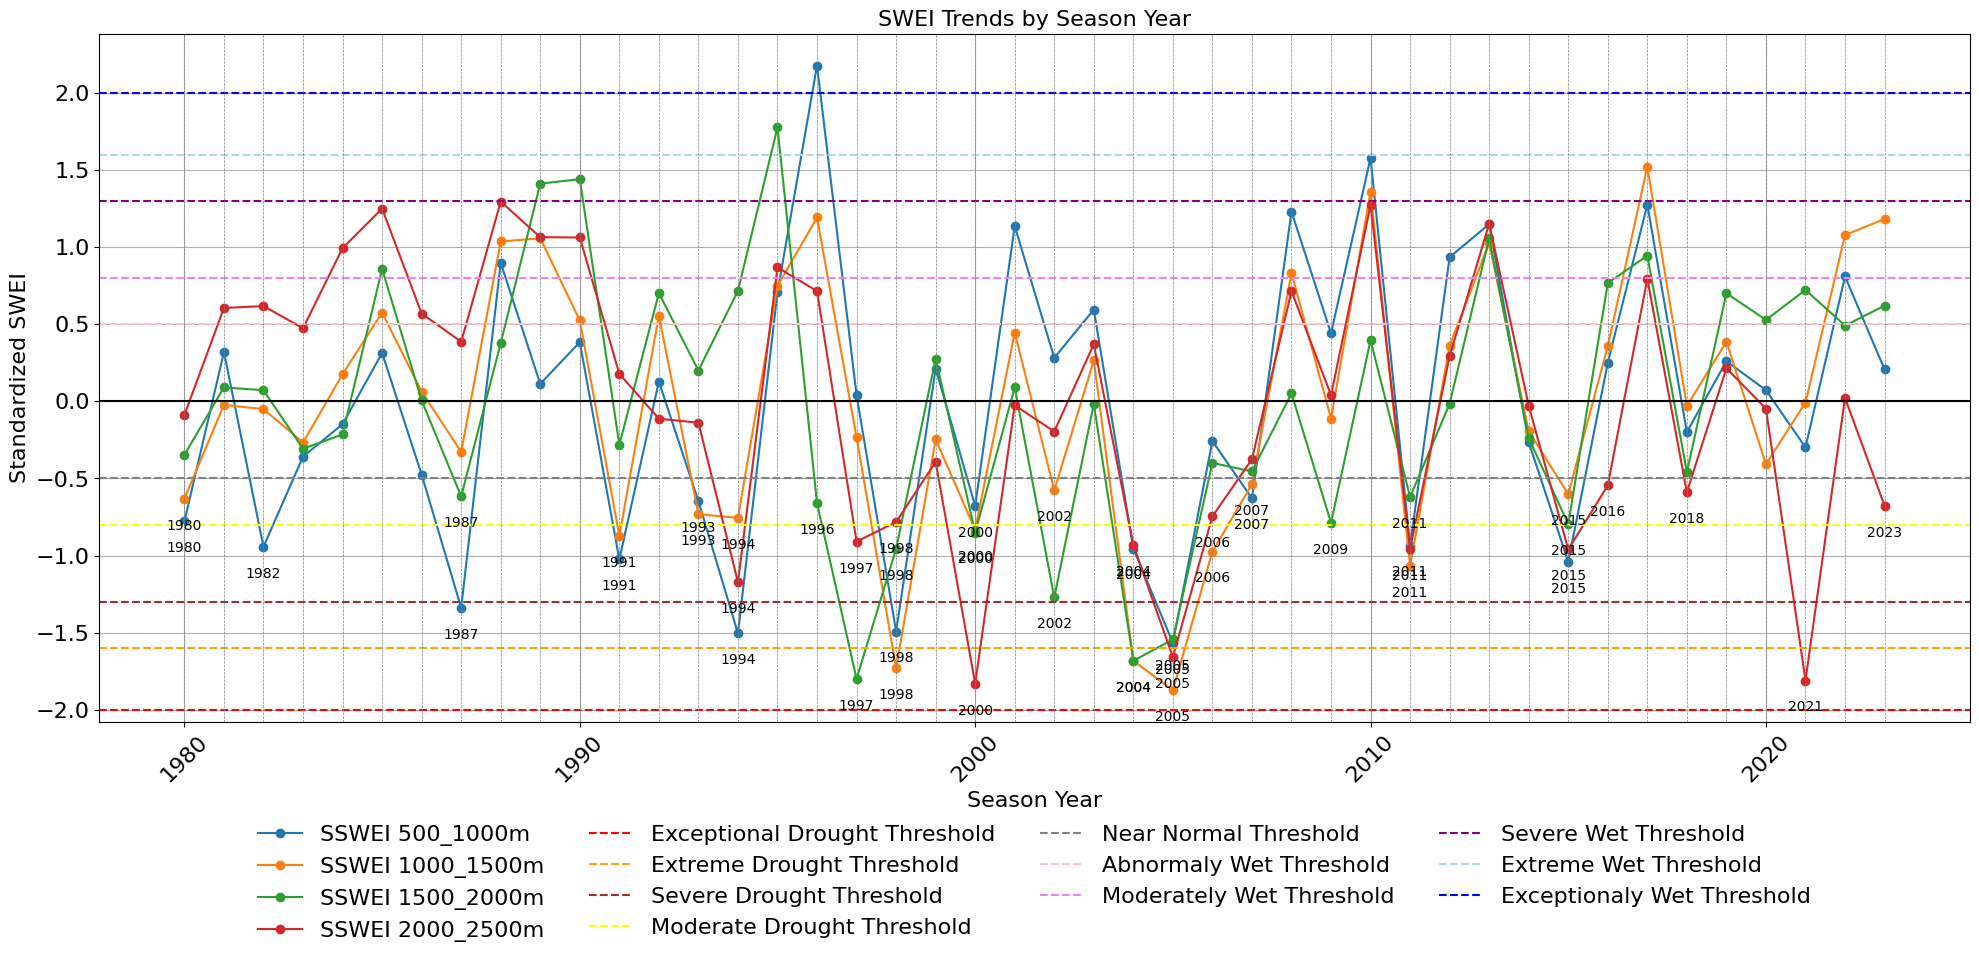

In [19]:
#6. Plotting the results
# Prepare data for plotting
plot_data = average_SSWEI_per_year.sort_values(by='season_year')
plt.figure(figsize=(20, 10))
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    plt.plot(plot_data['season_year'], plot_data[col], marker='o', label=f'SSWEI {col}')

# Add thresholds for drought classifications
plt.axhline(-2.0, color='r', linestyle='--', label='Exceptional Drought Threshold')
plt.axhline(-1.6, color='orange', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.3, color='brown', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-0.8, color='yellow', linestyle='--', label='Moderate Drought Threshold')
plt.axhline(-0.5, color='gray', linestyle='--', label='Near Normal Threshold')
plt.axhline(0.5, color='pink', linestyle='--', label='Abnormaly Wet Threshold')
plt.axhline(0.8, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.3, color='purple', linestyle='--', label='Severe Wet Threshold')
plt.axhline(1.6, color='lightblue', linestyle='--', label='Extreme Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Exceptionaly Wet Threshold')

# trend line
#z = np.polyfit(plot_data['Season_year'], plot_data['SSWEI'], 1)
#p = np.poly1d(z)
#plt.plot(plot_data['Season_year'],p(plot_data['Season_year']),"g--", label='trend line')

# Customize the plot
plt.title('SWEI Trends by Season Year',fontsize=16)
plt.xlabel('Season Year',fontsize=16)
plt.ylabel('Standardized SWEI',fontsize=16)
plt.xticks(rotation=45,fontsize=16)
plt.yticks(fontsize=16)
# put legend outside the plot right top 
plt.legend(['SSWEI 500_1000m', 'SSWEI 1000_1500m', 'SSWEI 1500_2000m', 'SSWEI 2000_2500m',
            'Exceptional Drought Threshold', 'Extreme Drought Threshold', 'Severe Drought Threshold','Moderate Drought Threshold',
            'Near Normal Threshold', 'Abnormaly Wet Threshold', 'Moderately Wet Threshold',
            'Severe Wet Threshold', 'Extreme Wet Threshold','Exceptionaly Wet Threshold'],
           loc='lower center', bbox_to_anchor=(0.5, -0.35), ncol=4, fontsize=16, frameon=False)
# Add gridlines for each year
for year in plot_data['season_year'].unique():
    plt.axvline(year, color='gray', linestyle='--', linewidth=0.5)
# Add years to SSWEI < -0.5 for each elevation category
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    for i, row in plot_data.iterrows():
        if row[col] < -0.5:
            plt.text(row['season_year'], row[col] - 0.2, str(row['season_year']), fontsize=10, color='black', ha='center')
plt.grid()
plt.axhline(0, color='black', linewidth=1.5, linestyle='-', label='y=0')
plt.tight_layout()
plt.savefig(config['plots'] /  'SWEI_trends.png')
plt.show()
plt.close()

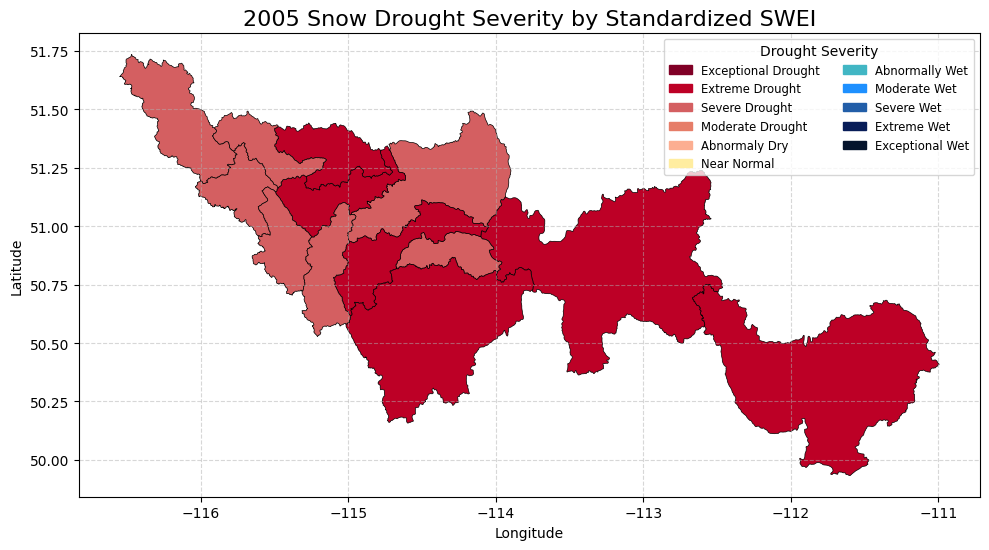

In [24]:
# Filter onset_to_peak for the year 2005
onset_to_peak_2005 = average_SSWEI_per_year[average_SSWEI_per_year['season_year'] == 2005]

# Get the classification for 2005 from plot_data
classifications_2005 = plot_data[plot_data['season_year'] == 2005][[
    'Classification_1000_1500m', 'Classification_1500_2000m', 'Classification_2000_2500m', 'Classification_500_1000m'
]].iloc[0]

# Map elevation category to classification
elev_class_map = {
    '1000_1500m': classifications_2005['Classification_1000_1500m'],
    '1500_2000m': classifications_2005['Classification_1500_2000m'],
    '2000_2500m': classifications_2005['Classification_2000_2500m'],
    '500_1000m': classifications_2005['Classification_500_1000m'],
}
# open Bow Basin shapefile
bow_basin = gpd.read_file(config['shapefile_dir'])

# Add drought classification to the Bow Basin shapefile
bow_basin['Drought_Classification'] = bow_basin['elev_class'].map(elev_class_map)

# Add drought classification to onset_to_peak_2005
onset_to_peak_2005 = onset_to_peak_2005.copy()

# detect elevation-category columns (use elev_order if present, otherwise fall back to desired_order)
elev_ref = globals().get('elev_order', None)
if elev_ref is None:
    elev_ref = globals().get('desired_order', ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m'])

elev_cols = [c for c in onset_to_peak_2005.columns if c in elev_ref]

# if the DF is wide (columns per elevation) -> melt to long and map
if elev_cols and 'Elevation_Category' not in onset_to_peak_2005.columns:
    onset_to_peak_2005 = (
        onset_to_peak_2005.reset_index(drop=True)
        .melt(id_vars=['season_year'], value_vars=elev_cols,
              var_name='Elevation_Category', value_name='SSWEI')
    )
    onset_to_peak_2005['Drought_Classification'] = onset_to_peak_2005['Elevation_Category'].map(elev_class_map)
else:
    # if already long / has Elevation_Category column, map directly
    onset_to_peak_2005['Drought_Classification'] = onset_to_peak_2005['Elevation_Category'].map(elev_class_map)

# Define a color map for drought severity
severity_colors = {
    'Exceptional Drought': '#800026',
    'Extreme Drought': '#BD0026',
    'Severe Drought': "#D45F61",
    'Moderate Drought': "#E67D68",
    'Abnormaly Dry': "#FCAE91",
    'Near Normal': '#FFEDA0',
    'Abnormally Wet': '#41B6C4',
    'Moderate Wet': '#1E90FF',
    'Severe Wet': '#225EA8',
    'Extreme Wet': '#081D58',
    'Exceptional Wet': "#04142C",
}

# Assign colors to each polygon based on drought classification (fill missing with light gray)
bow_basin['color'] = bow_basin['Drought_Classification'].map(severity_colors).fillna('#dddddd')

# Plot the Bow Basin colored by drought severity
fig, ax = plt.subplots(figsize=(10, 8))
bow_basin.plot(ax=ax, color=bow_basin['color'], edgecolor='black', linewidth=0.5)

# Create a full legend showing all severity categories (even if not present on the map)
legend_order = list(severity_colors.keys())
legend_patches = [mpatches.Patch(color=severity_colors[k], label=k) for k in legend_order]

# Place the legend; use multiple columns to keep it compact
plt.legend(handles=legend_patches, title='Drought Severity', loc='upper right',
           bbox_to_anchor=(1.00, 1.00), ncol=2, fontsize='small', frameon=True)

plt.title('2005 Snow Drought Severity by Standardized SWEI', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save to an existing path in config (use 'plots' to avoid missing key)
outpath = config.get('plots', config.get('output_dir'))
plt.savefig(Path(outpath) / 'bow_basin_drought_severity_2005.png', dpi=150)
plt.show()

# 2005 SWEI

In [25]:
# Extract season-based (season_year == 2005) and calendar-year (year == 2005) subsets from swe_df
if 'swe_df' not in globals():
    raise NameError("swe_df not found. Run the previous cells that create swe_df first.")

# season labeled 2005 (Oct 2005 - May 2006)
swe_df_2005_season = swe_df[swe_df['season_year'] == 2005].copy()

# calendar year 2005 (all rows whose datetime index or time column is in 2005)
if np.issubdtype(swe_df.index.dtype, np.datetime64):
    swe_df_2005_calendar = swe_df[swe_df.index.year == 2005].copy()
else:
    if 'time' in swe_df.columns:
        swe_df_2005_calendar = swe_df[pd.to_datetime(swe_df['time'], errors='coerce').dt.year == 2005].copy()
    elif 'date' in swe_df.columns:
        swe_df_2005_calendar = swe_df[pd.to_datetime(swe_df['date'], errors='coerce').dt.year == 2005].copy()
    else:
        swe_df_2005_calendar = pd.DataFrame()

print(f"Rows (season_year == 2005): {len(swe_df_2005_season)}")
print(f"Rows (calendar year 2005): {len(swe_df_2005_calendar)}")


display(swe_df_2005_season.head())

Rows (season_year == 2005): 62451
Rows (calendar year 2005): 62451


Grid_id        time      lon      lat        SWE  \
date                                                           
2005-10-01        1  2005-10-01 -116.138  51.3346  11.274902   
2005-10-02        1  2005-10-02 -116.138  51.3346  14.750000   
2005-10-03        1  2005-10-03 -116.138  51.3346  14.875000   
2005-10-04        1  2005-10-04 -116.138  51.3346  15.625000   
2005-10-05        1  2005-10-05 -116.138  51.3346  14.875000   

           Elevation_Category  season_year  daily_SWE_change   perturb_SWE  
date                                                                        
2005-10-01         2000_2500m         2005          3.475098  3.475098e+00  
2005-10-02         2000_2500m         2005          0.125000  1.250000e-01  
2005-10-03         2000_2500m         2005          0.750000  7.500000e-01  
2005-10-04         2000_2500m         2005          0.000000  8.786178e-07  
2005-10-05         2000_2500m         2005          0.000000  6.575419e-07

In [26]:
# perturb daily_SWE_change for both subsets
swe_df_2005_season['perturb_SWE'] = sswei.perturb_zeros(swe_df_2005_season['daily_SWE_change'])

display(swe_df_2005_season.head())


Grid_id        time      lon      lat        SWE  \
date                                                           
2005-10-01        1  2005-10-01 -116.138  51.3346  11.274902   
2005-10-02        1  2005-10-02 -116.138  51.3346  14.750000   
2005-10-03        1  2005-10-03 -116.138  51.3346  14.875000   
2005-10-04        1  2005-10-04 -116.138  51.3346  15.625000   
2005-10-05        1  2005-10-05 -116.138  51.3346  14.875000   

           Elevation_Category  season_year  daily_SWE_change   perturb_SWE  
date                                                                        
2005-10-01         2000_2500m         2005          3.475098  3.475098e+00  
2005-10-02         2000_2500m         2005          0.125000  1.250000e-01  
2005-10-03         2000_2500m         2005          0.750000  7.500000e-01  
2005-10-04         2000_2500m         2005          0.000000  6.631420e-07  
2005-10-05         2000_2500m         2005          0.000000  2.930045e-06

In [27]:
# monthly integration of SWE for swe_df_2005_season per Grid_id
# outputs monthly_swe_integration (Grid_id, season_year, month, month_label, n_obs, SWE_integration)
if 'swe_df_2005_season' not in globals():
    raise NameError("swe_df_2005_season not found. Run the cells that create it first.")

df = swe_df_2005_season.reset_index().rename(columns={'date': 'date'})  # bring date back as column

# ensure we have a datetime 'date' column and a numeric 'month' column for grouping
if 'date' not in df.columns or not np.issubdtype(df['date'].dtype, np.datetime64):
    if 'time' in df.columns:
        df['date'] = pd.to_datetime(df['time'], errors='coerce')
    else:
        # reset_index above should have created 'date' from the index name; try converting it anyway
        df['date'] = pd.to_datetime(df['date'], errors='coerce')

if df['date'].isna().all():
    raise KeyError("No valid datetime values found in 'date'/'time' columns of swe_df_2005_season")

df['month'] = df['date'].dt.month

def integrate_month_group(g: pd.DataFrame) -> pd.Series:
    # expect g to have columns: date, SWE
    times = pd.to_datetime(g['date'], errors='coerce')
    swe = g['SWE'].astype(float)
    valid = (~times.isna()) & (~swe.isna())
    if valid.sum() < 2:
        return pd.Series({
            'n_obs': int(valid.sum()),
            'SWE_integration': np.nan
        })
    times = times[valid].sort_values()
    swe_vals = swe[valid].values[np.argsort(times)]
    # compute days since month start for numeric x axis
    days = (times - times.min()).dt.total_seconds() / 86400.0
    total = trapz(swe_vals, days)
    return pd.Series({
        'n_obs': int(len(swe_vals)),
        'SWE_integration': float(total)
    })

grouped = df.groupby(['Grid_id', 'season_year', 'month','Elevation_Category'], observed=True)
monthly_swe_integration = grouped.apply(integrate_month_group).reset_index()

# add month_label
month_labels = {10:'Oct',11:'Nov',12:'Dec',1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May'}
monthly_swe_integration['month_label'] = monthly_swe_integration['month'].map(month_labels)

# reorder columns
monthly_swe_integration = monthly_swe_integration[['Grid_id','season_year','month','month_label','n_obs','Elevation_Category','SWE_integration']]

# save and display
out_file = config['output_dir'] / 'monthly_SWE_integration_by_grid_2005.csv'
monthly_swe_integration.to_csv(out_file, index=False)
print(f"Saved monthly SWE integration per Grid_id to: {out_file}")
display(monthly_swe_integration.head())

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\2632770141.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = trapz(swe_vals, days)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\2632770141.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = trapz(swe_vals, days)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\2632770141.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = trapz(swe_vals, days)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\2632770141.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = trapz(swe_vals, da

Saved monthly SWE integration per Grid_id to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SWE_integration_by_grid_2005.csv


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\2632770141.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = trapz(swe_vals, days)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\2632770141.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = trapz(swe_vals, days)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\2632770141.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = trapz(swe_vals, days)
C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\2632770141.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  total = trapz(swe_vals, da

Grid_id  season_year  month month_label  n_obs Elevation_Category  \
0        1         2005      1         Jan   31.0         2000_2500m   
1        1         2005      2         Feb   28.0         2000_2500m   
2        1         2005      3         Mar   31.0         2000_2500m   
3        1         2005      4         Apr   30.0         2000_2500m   
4        1         2005      5         May   31.0         2000_2500m   

   SWE_integration  
0      2861.312500  
1      3349.937500  
2      4379.125000  
3      4084.704590  
4      1579.161132

In [28]:
# Apply gringorten_probabilities grouped by coordinate_id
monthly_swe_integration['gringorten_probability'] = monthly_swe_integration.groupby('Grid_id')['SWE_integration'].transform(sswei.gringorten_probabilities)
# Display the updated DataFrame
display(monthly_swe_integration)

Grid_id  season_year  month month_label  n_obs Elevation_Category  \
0           1         2005      1         Jan   31.0         2000_2500m   
1           1         2005      2         Feb   28.0         2000_2500m   
2           1         2005      3         Mar   31.0         2000_2500m   
3           1         2005      4         Apr   30.0         2000_2500m   
4           1         2005      5         May   31.0         2000_2500m   
...       ...          ...    ...         ...    ...                ...   
2051      257         2005      4         Apr   30.0          500_1000m   
2052      257         2005      5         May   31.0          500_1000m   
2053      257         2005     10         Oct   31.0          500_1000m   
2054      257         2005     11         Nov   30.0          500_1000m   
2055      257         2005     12         Dec   31.0          500_1000m   

      SWE_integration  gringorten_probability  
0         2861.312500                0.561576  
1         3349.937500                0.684729  
2         4379.125000                0.931034  
3         4084.704590                0.807882  
4         1579.161132                0.315271  
...               ...                     ...  
2051         0.260742                0.315271  
2052         0.000000                0.068966  
2053         0.251648                0.192118  
2054         5.447998                0.438424  
2055        81.875977                0.684729  

[2056 rows x 8 columns]

In [29]:
# 4. Compute standardized SWEI
# Compute SSWEI grouped by coordinate_id
monthly_swe_integration['SSWEI'] = monthly_swe_integration.groupby('Grid_id')['gringorten_probability'].transform(sswei.compute_swei)

# Display the updated DataFrame
display(monthly_swe_integration)

Grid_id  season_year  month month_label  n_obs Elevation_Category  \
0           1         2005      1         Jan   31.0         2000_2500m   
1           1         2005      2         Feb   28.0         2000_2500m   
2           1         2005      3         Mar   31.0         2000_2500m   
3           1         2005      4         Apr   30.0         2000_2500m   
4           1         2005      5         May   31.0         2000_2500m   
...       ...          ...    ...         ...    ...                ...   
2051      257         2005      4         Apr   30.0          500_1000m   
2052      257         2005      5         May   31.0          500_1000m   
2053      257         2005     10         Oct   31.0          500_1000m   
2054      257         2005     11         Nov   30.0          500_1000m   
2055      257         2005     12         Dec   31.0          500_1000m   

      SWE_integration  gringorten_probability     SSWEI  
0         2861.312500                0.561576  0.154967  
1         3349.937500                0.684729  0.480964  
2         4379.125000                0.931034  1.483540  
3         4084.704590                0.807882  0.870117  
4         1579.161132                0.315271 -0.480964  
...               ...                     ...       ...  
2051         0.260742                0.315271 -0.480964  
2052         0.000000                0.068966 -1.483540  
2053         0.251648                0.192118 -0.870117  
2054         5.447998                0.438424 -0.154967  
2055        81.875977                0.684729  0.480964  

[2056 rows x 9 columns]

In [30]:
# Group by month and Elevation_Category, then pivot to have each elevation as a column
average_SSWEI = monthly_swe_integration.groupby(['month', 'Elevation_Category'])['SSWEI'].mean().reset_index()
average_SSWEI = average_SSWEI.pivot(index='month', columns='Elevation_Category', values='SSWEI').reset_index()

out_2005_long = config['output_dir'] / 'monthly_SWEI_2005_long.csv'
average_SSWEI.to_csv(out_2005_long, index=False)
print(f"Saved monthly SWEI for 2005 (long) to: {out_2005_long}")
# Display the result
display(average_SSWEI)

Saved monthly SWEI for 2005 (long) to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SWEI_2005_long.csv


Elevation_Category  month  1000_1500m  1500_2000m  2000_2500m  500_1000m
0                       1   -0.082649   -0.070957    0.245064   0.417232
1                       2    0.627864    0.169559    0.427731   0.429899
2                       3    1.463092    1.422198    1.456277   1.478063
3                       4   -0.618158   -0.341891    0.558838  -0.767177
4                       5   -1.409226   -1.219167   -0.925401  -1.353153
5                      10   -0.807238   -0.929162   -1.275402  -0.714291
6                      11    0.104382    0.099932   -0.524131  -0.149433
7                      12    0.721932    0.869488    0.037024   0.658860

In [34]:
# 5. Classification

# Apply the classify_drought function to each value in the average_SSWEI column
# Apply the classify_drought function to each elevation column
for col in ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m']:
    average_SSWEI[f'Classification_{col}'] = average_SSWEI[col].apply(sswei.classify_drought)

# Do not rename columns here, as the DataFrame now has more columns after classification
# If you want to keep only certain columns, select them explicitly, e.g.:
# average_SSWEI_per_year = average_SSWEI_per_year[['Season_year', '1000_1500m', 'Classification_1000_1500m', ...]]

#remove decimal points from season year
average_SSWEI['season_year'] = average_SSWEI['month'].astype(int)

# Display the updated DataFrame
display(average_SSWEI)

Elevation_Category  month  1000_1500m  1500_2000m  2000_2500m  500_1000m  \
0                       1   -0.082649   -0.070957    0.245064   0.417232   
1                       2    0.627864    0.169559    0.427731   0.429899   
2                       3    1.463092    1.422198    1.456277   1.478063   
3                       4   -0.618158   -0.341891    0.558838  -0.767177   
4                       5   -1.409226   -1.219167   -0.925401  -1.353153   
5                      10   -0.807238   -0.929162   -1.275402  -0.714291   
6                      11    0.104382    0.099932   -0.524131  -0.149433   
7                      12    0.721932    0.869488    0.037024   0.658860   

Elevation_Category Classification_1000_1500m Classification_1500_2000m  \
0                                Near Normal               Near Normal   
1                             Abnormally Wet               Near Normal   
2                               Severely Wet              Severely Wet   
3                             Abnormally Dry               Near Normal   
4                             Severe Drought          Moderate Drought   
5                           Moderate Drought          Moderate Drought   
6                                Near Normal               Near Normal   
7                             Abnormally Wet            Moderately Wet   

Elevation_Category Classification_2000_2500m Classification_500_1000m  \
0                                Near Normal              Near Normal   
1                                Near Normal              Near Normal   
2                               Severely Wet             Severely Wet   
3                             Abnormally Wet           Abnormally Dry   
4                           Moderate Drought           Severe Drought   
5                           Moderate Drought           Abnormally Dry   
6                             Abnormally Dry              Near Normal   
7                                Near Normal           Abnormally Wet   

Elevation_Category  season_year  
0                             1  
1                             2  
2                             3  
3                             4  
4                             5  
5                            10  
6                            11  
7                            12

# SPI calculation

In [36]:
# Extract precipitation time series for SPI calculations (monthly and seasonal totals)
# Assumes `winter_df` (filtered to Oct-May) already exists in the notebook.

df_prec = winter_df.reset_index()  # bring date back as a column if it's the index

# keep only the requested columns (rename to lowercase names for consistency)
_keep = ['date', 'Grid_id', 'lon', 'lat', 'Precipitation', 'Elevation_Category', 'month', 'season_year']
_available = [c for c in _keep if c in df_prec.columns]
df_prec = df_prec[_available].rename(columns={
    'Grid_id': 'Grid_id',
    'Precipitation': 'Precipitation',
    'Elevation_Category': 'Elevation_Category',
    'season_year': 'Season_year'
})

# ensure date is datetime
df_prec['date'] = pd.to_datetime(df_prec['date'], errors='coerce')

display(df_prec.head())

date  Grid_id       lon      lat  Precipitation Elevation_Category  \
0 1980-10-10        1 -116.1380  51.3346       0.009879         2000_2500m   
1 1983-10-12        2 -116.1875  51.4191       0.023846         2000_2500m   
2 1980-12-11        2 -116.1875  51.4191       4.578907         2000_2500m   
3 1982-10-29        2 -116.1875  51.4191       1.777088         2000_2500m   
4 1982-01-18        2 -116.1875  51.4191       1.890419         2000_2500m   

   month  Season_year  
0     10         1980  
1     10         1983  
2     12         1980  
3     10         1982  
4      1         1981

In [37]:
# Calculate monthly precipitation for each season year and grid point
monthly_precip = (
    df_prec
    .groupby(['Grid_id', 'Season_year', pd.Grouper(key='date', freq='M')])['Precipitation']
    .sum()
    .reset_index()
)

# Add elevation category for each Grid_id
# Get unique mapping from Grid_id to Elevation_Category
elevation_map = df_prec[['Grid_id', 'Elevation_Category']].drop_duplicates().set_index('Grid_id')['Elevation_Category']
monthly_precip['Elevation_Category'] = monthly_precip['Grid_id'].map(elevation_map)

display(monthly_precip.head())

C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37080\3937404802.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(['Grid_id', 'Season_year', pd.Grouper(key='date', freq='M')])['Precipitation']


Grid_id  Season_year       date  Precipitation Elevation_Category
0        1         1980 1980-10-31      15.461886         2000_2500m
1        1         1980 1980-11-30      50.295086         2000_2500m
2        1         1980 1980-12-31     108.955549         2000_2500m
3        1         1980 1981-01-31      13.916898         2000_2500m
4        1         1980 1981-02-28      38.431036         2000_2500m

In [ ]:
# Calculate monthly average precipitation for each Elevation_Category, Season_year, and month
monthly_avg = (
    monthly_precip
    .groupby(['Elevation_Category', 'Season_year', monthly_precip['date']])['Precipitation']
    .mean()
    .unstack(level=0)  # Elevation_Category as columns
)

# Rename columns to match the format "2000-2500m_P"
monthly_avg.columns = [f"{col}_P" for col in monthly_avg.columns]

display(monthly_avg.head(10))

1000_1500m_P  1500_2000m_P  2000_2500m_P  500_1000m_P
Season_year date                                                             
1980        1980-10-31     23.722882     32.100595     23.455035    27.613888
            1980-11-30     23.173287     32.786186     52.304052    12.598151
            1980-12-31     24.672522     39.349471     94.355993    27.466716
            1981-01-31      6.245697      9.145041     11.316449     8.226255
            1981-02-28      8.437483     13.018755     29.459216     4.767321
            1981-03-31     15.564112     10.314856     14.930461    22.119542
            1981-04-30      7.126947     12.134646     29.451566     7.069899
            1981-05-31    133.068552    162.022685     95.782016    96.181287
1981        1981-10-31     20.885100     15.466855     33.907494    22.720848
            1981-11-30      4.466762      6.709451     12.339459     7.268729

In [ ]:
# Save the combined data to a CSV file
output_file_precip = config['output_dir'] / 'bow_casr_winter_precipitation_data.csv'
monthly_avg.to_csv(output_file_precip, index=True)


In [ ]:
import warnings

# Monthly SPI calculation (new cell)
# Uses monthly_precip if available; otherwise rebuilds it from df_prec.

warnings.filterwarnings("ignore", category=RuntimeWarning)

# months considered (Oct -> May)
months_order = [10, 11, 12, 1, 2, 3, 4, 5]
month_labels = {10:'Oct',11:'Nov',12:'Dec',1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May'}

# Ensure monthly_precip exists (it should from earlier cells); if not, recreate from df_prec
if 'monthly_precip' not in globals():
    # df_prec expected to exist (created earlier from winter_df)
    monthly_precip = (
        df_prec
        .groupby(['Grid_id', 'Season_year', pd.Grouper(key='date', freq='M')])['Precipitation']
        .sum()
        .reset_index()
    )
    elevation_map = df_prec[['Grid_id', 'Elevation_Category']].drop_duplicates().set_index('Grid_id')['Elevation_Category']
    monthly_precip['Elevation_Category'] = monthly_precip['Grid_id'].map(elevation_map)

# add month column
monthly_precip['month'] = pd.to_datetime(monthly_precip['date']).dt.month

# Aggregate across grid points to obtain area-mean monthly precipitation per Elevation_Category
agg = (
    monthly_precip.loc[monthly_precip['month'].isin(months_order)]
    .groupby(['Elevation_Category', 'Season_year', 'month'], observed=True)['Precipitation']
    .mean()
    .reset_index()
)

# season range to anchor index order
season_range = sorted(agg['Season_year'].unique())

rows = []
for elev in sorted(agg['Elevation_Category'].unique()):
    for m in months_order:
        ser = agg.loc[(agg['Elevation_Category'] == elev) & (agg['month'] == m), ['Season_year', 'Precipitation']].set_index('Season_year').reindex(season_range)
        vals = ser['Precipitation'].values.astype(float)
        # prepare output container for this elev-month
        spi_vals = np.full(len(season_range), np.nan)
        # fit gamma to positive precipitation values (require minimum samples)
        valid_idx = ~np.isnan(vals) & (vals > 0)
        if valid_idx.sum() >= 10:
            try:
                shape, loc, scale = gamma.fit(vals[valid_idx], floc=0)
                # compute cdf for each season value (NaN stays NaN)
                cdf = np.full(len(vals), np.nan)
                for i, v in enumerate(vals):
                    if not np.isnan(v):
                        # gamma.cdf handles zero/positive values; clip later
                        cdf[i] = gamma.cdf(v, shape, loc=loc, scale=scale)
                # avoid 0/1
                cdf = np.asarray(cdf, dtype=float)
                mask = ~np.isnan(cdf)
                cdf[mask] = np.clip(cdf[mask], 1e-6, 1 - 1e-6)
                spi_vals[mask] = norm.ppf(cdf[mask])
            except Exception:
                # fallback empirical plotting position
                ranked = pd.Series(vals).rank(method='average', na_option='keep').values
                n = np.sum(~np.isnan(vals))
                if n > 0:
                    pp = ranked / (n + 1)
                    mask = ~np.isnan(vals)
                    spi_vals[mask] = norm.ppf(np.clip(pp[mask], 1e-6, 1 - 1e-6))
        else:
            # not enough data -> leave NaNs
            pass

        for yr, spi_val in zip(season_range, spi_vals):
            rows.append({
                'Season_year': yr,
                'Elevation_Category': elev,
                'month': m,
                'month_label': month_labels[m],
                'Precipitation': float(agg.loc[(agg['Elevation_Category']==elev)&(agg['Season_year']==yr)&(agg['month']==m), 'Precipitation'].squeeze()) if ((agg['Elevation_Category']==elev)&(agg['Season_year']==yr)&(agg['month']==m)).any() else np.nan,
                'SPI': float(spi_val) if not np.isnan(spi_val) else np.nan
            })

monthly_spi = pd.DataFrame(rows)

# pivot to wide format if useful: index Season_year, columns like (Elevation, month)
monthly_spi_wide = monthly_spi.pivot_table(index='Season_year', columns=['Elevation_Category', 'month'], values='SPI')

# Save results
out_csv = config['output_dir'] / 'monthly_SPI_by_elevation.csv'
monthly_spi.to_csv(out_csv, index=False)
out_csv_wide = config['output_dir'] / 'monthly_SPI_by_elevation_wide.csv'
monthly_spi_wide.to_csv(out_csv_wide)

print(f"Monthly SPI computed. Long CSV: {out_csv}, Wide CSV: {out_csv_wide}")
display(monthly_spi.head())

Monthly SPI computed. Long CSV: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SPI_by_elevation.csv, Wide CSV: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SPI_by_elevation_wide.csv


Season_year Elevation_Category  month month_label  Precipitation       SPI
0         1980         1000_1500m     10         Oct      23.722882  0.298526
1         1981         1000_1500m     10         Oct      20.885100  0.075540
2         1982         1000_1500m     10         Oct       5.255342 -1.856725
3         1983         1000_1500m     10         Oct       5.152061 -1.879497
4         1984         1000_1500m     10         Oct      29.395997  0.696169

In [ ]:
# Filter monthly_spi for Season_year == 2005, display and save
if 'monthly_spi' not in globals():
    raise NameError("monthly_spi not found. Run the monthly SPI computation cell first.")

monthly_spi_2005 = monthly_spi[monthly_spi['Season_year'] == 2005].reset_index(drop=True)
display(monthly_spi_2005)

out_csv = config['output_dir'] / 'monthly_SPI_2005.csv'
monthly_spi_2005.to_csv(out_csv, index=False)
print(f"Saved filtered monthly SPI for 2005 to: {out_csv}")

Season_year Elevation_Category  month month_label  Precipitation       SPI
0          2005         1000_1500m     10         Oct      19.361433 -0.052669
1          2005         1000_1500m     11         Nov      16.813028  0.131721
2          2005         1000_1500m     12         Dec       4.272242 -1.209708
3          2005         1000_1500m      1         Jan       7.627983 -0.349224
4          2005         1000_1500m      2         Feb      16.604584  0.466405
5          2005         1000_1500m      3         Mar      11.131235 -0.891061
6          2005         1000_1500m      4         Apr      25.034489 -0.159193
7          2005         1000_1500m      5         May      46.417620 -0.376534
8          2005         1500_2000m     10         Oct      27.055029 -0.013912
9          2005         1500_2000m     11         Nov      25.732530  0.276616
10         2005         1500_2000m     12         Dec       8.153517 -1.036021
11         2005         1500_2000m      1         Jan      10.833365 -0.382049
12         2005         1500_2000m      2         Feb      16.720673  0.035853
13         2005         1500_2000m      3         Mar      10.045767 -1.640496
14         2005         1500_2000m      4         Apr      31.360170 -0.427991
15         2005         1500_2000m      5         May      50.580815 -0.464000
16         2005         2000_2500m     10         Oct      49.888281  0.549937
17         2005         2000_2500m     11         Nov      27.622360 -0.712863
18         2005         2000_2500m     12         Dec      14.656927 -1.424022
19         2005         2000_2500m      1         Jan      37.117580  0.390312
20         2005         2000_2500m      2         Feb      23.170830 -0.213536
21         2005         2000_2500m      3         Mar      24.280251 -0.784207
22         2005         2000_2500m      4         Apr      47.360665  0.554801
23         2005         2000_2500m      5         May      46.298192 -0.473230
24         2005          500_1000m     10         Oct      18.897848  0.393079
25         2005          500_1000m     11         Nov      11.720871 -0.074196
26         2005          500_1000m     12         Dec       5.538395 -0.908139
27         2005          500_1000m      1         Jan      11.006425  0.233379
28         2005          500_1000m      2         Feb      11.898232  0.368217
29         2005          500_1000m      3         Mar      18.618927  0.422021
30         2005          500_1000m      4         Apr      30.281445  0.658789
31         2005          500_1000m      5         May      51.195913  0.435772

Saved filtered monthly SPI for 2005 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SPI_2005.csv


In [ ]:
# Normalize SPI values in monthly_spi_2005 to the range [-1, 1] per elevation category
# (uses MinMaxScaler already imported earlier in the notebook)

# Ensure monthly_spi_2005 exists; if not, create it from monthly_spi
if 'monthly_spi_2005' not in globals():
    if 'monthly_spi' in globals():
        monthly_spi_2005 = monthly_spi[monthly_spi['Season_year'] == 2005].reset_index(drop=True)
    else:
        raise NameError("monthly_spi not found. Run the monthly SPI computation cell first.")

# copy to avoid modifying original unintentionally
monthly_spi_2005 = monthly_spi_2005.copy()

# Prepare output column
monthly_spi_2005['SPI_normalized'] = np.nan

scaler = MinMaxScaler(feature_range=(-1, 1))

for elev in monthly_spi_2005['Elevation_Category'].unique():
    mask = monthly_spi_2005['Elevation_Category'] == elev
    vals = monthly_spi_2005.loc[mask, 'SPI'].to_numpy().astype(float)

    # handle cases with insufficient valid values
    valid_mask = ~np.isnan(vals)
    if valid_mask.sum() == 0:
        monthly_spi_2005.loc[mask, 'SPI_normalized'] = np.nan
        continue
    if valid_mask.sum() == 1:
        # single value -> map to 0
        monthly_spi_2005.loc[mask, 'SPI_normalized'] = 0.0
        continue

    # scale only the valid entries
    try:
        scaled = vals.copy()
        scaled_valid = scaler.fit_transform(vals[valid_mask].reshape(-1, 1)).ravel()
        scaled[valid_mask] = scaled_valid
        monthly_spi_2005.loc[mask, 'SPI_normalized'] = scaled
    except Exception:
        # fallback: z-score then clip to [-1,1]
        series = pd.Series(vals)
        z = (series - series.mean()) / (series.std(ddof=0) if series.std(ddof=0) != 0 else 1.0)
        monthly_spi_2005.loc[mask, 'SPI_normalized'] = np.clip(z, -1, 1)

# Save and display
out_file = config['output_dir'] / 'monthly_SPI_2005_normalized.csv'
monthly_spi_2005.to_csv(out_file, index=False)
print(f"Saved normalized monthly SPI for 2005 to: {out_file}")
display(monthly_spi_2005)

Saved normalized monthly SPI for 2005 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SPI_2005_normalized.csv


Season_year Elevation_Category  month month_label  Precipitation  \
0          2005         1000_1500m     10         Oct      19.361433   
1          2005         1000_1500m     11         Nov      16.813028   
2          2005         1000_1500m     12         Dec       4.272242   
3          2005         1000_1500m      1         Jan       7.627983   
4          2005         1000_1500m      2         Feb      16.604584   
5          2005         1000_1500m      3         Mar      11.131235   
6          2005         1000_1500m      4         Apr      25.034489   
7          2005         1000_1500m      5         May      46.417620   
8          2005         1500_2000m     10         Oct      27.055029   
9          2005         1500_2000m     11         Nov      25.732530   
10         2005         1500_2000m     12         Dec       8.153517   
11         2005         1500_2000m      1         Jan      10.833365   
12         2005         1500_2000m      2         Feb      16.720673   
13         2005         1500_2000m      3         Mar      10.045767   
14         2005         1500_2000m      4         Apr      31.360170   
15         2005         1500_2000m      5         May      50.580815   
16         2005         2000_2500m     10         Oct      49.888281   
17         2005         2000_2500m     11         Nov      27.622360   
18         2005         2000_2500m     12         Dec      14.656927   
19         2005         2000_2500m      1         Jan      37.117580   
20         2005         2000_2500m      2         Feb      23.170830   
21         2005         2000_2500m      3         Mar      24.280251   
22         2005         2000_2500m      4         Apr      47.360665   
23         2005         2000_2500m      5         May      46.298192   
24         2005          500_1000m     10         Oct      18.897848   
25         2005          500_1000m     11         Nov      11.720871   
26         2005          500_1000m     12         Dec       5.538395   
27         2005          500_1000m      1         Jan      11.006425   
28         2005          500_1000m      2         Feb      11.898232   
29         2005          500_1000m      3         Mar      18.618927   
30         2005          500_1000m      4         Apr      30.281445   
31         2005          500_1000m      5         May      51.195913   

         SPI  SPI_normalized  
0  -0.052669        0.380621  
1   0.131721        0.600642  
2  -1.209708       -1.000000  
3  -0.349224        0.026761  
4   0.466405        1.000000  
5  -0.891061       -0.619779  
6  -0.159193        0.253513  
7  -0.376534       -0.005826  
8  -0.013912        0.696911  
9   0.276616        1.000000  
10 -1.036021       -0.369390  
11 -0.382049        0.312858  
12  0.035853        0.748828  
13 -1.640496       -1.000000  
14 -0.427991        0.264929  
15 -0.464000        0.227363  
16  0.549937        0.995084  
17 -0.712863       -0.281231  
18 -1.424022       -1.000000  
19  0.390312        0.833751  
20 -0.213536        0.223440  
21 -0.784207       -0.353338  
22  0.554801        1.000000  
23 -0.473230       -0.039033  
24  0.393079        0.660853  
25 -0.074196        0.064431  
26 -0.908139       -1.000000  
27  0.233379        0.457015  
28  0.368217        0.629120  
29  0.422021        0.697794  
30  0.658789        1.000000  
31  0.435772        0.715345

2025-11-06 11:59:24,651 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 11:59:24,654 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 11:59:24,657 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 11:59:24,660 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-06 11:59:24,662 - INFO - Using categorical units to plot a list of strings that are all parsable as 

Saved 2005 monthly SPI plot to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\monthly_SPI_2005_plot.png


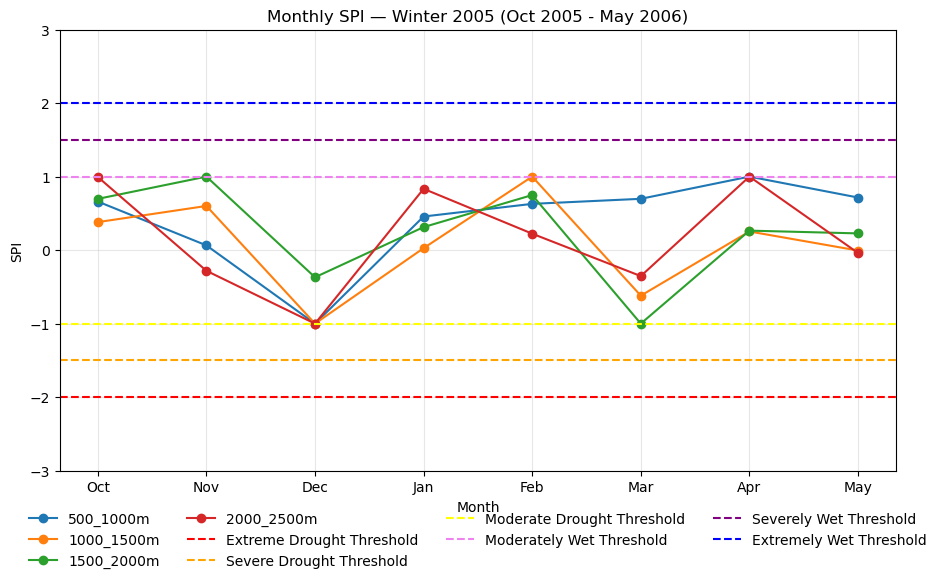

In [ ]:
# Plot monthly SPI for Season_year == 2005 (Oct 2005 - May 2006)
#df2005 = monthly_spi[monthly_spi_2005['Season_year'] == 2005].copy()

# desired months and labels (Oct -> May)
months_order = [10, 11, 12, 1, 2, 3, 4, 5]
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']

# pivot so columns are elevation categories, index is month
pivot_2005 = monthly_spi_2005.pivot(index='month', columns='Elevation_Category', values='SPI_normalized').reindex(months_order)

# elevation plotting order (keep only those present)
elev_order = [e for e in ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m'] if e in pivot_2005.columns]

plt.figure(figsize=(10, 6))
for elev in elev_order:
    plt.plot(month_labels, pivot_2005[elev].values, marker='o', label=f'{elev}')

# drought thresholds
plt.axhline(-2.0, color='r', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Moderate Drought Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Severely Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')


plt.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.250), frameon=False)
plt.title('Monthly SPI — Winter 2005 (Oct 2005 - May 2006)')
plt.xlabel('Month')
plt.ylabel('SPI')
plt.grid(alpha=0.3)
plt.ylim(-3, 3)
plt.tight_layout()

out_path = config['plots'] / 'monthly_SPI_2005_plot.png'
plt.savefig(out_path, dpi=150)
print(f"Saved 2005 monthly SPI plot to: {out_path}")
plt.show()

SPI - 8

In [39]:
display(monthly_precip.head())

Grid_id  Season_year       date  Precipitation Elevation_Category
0        1         1980 1980-10-31      15.461886         2000_2500m
1        1         1980 1980-11-30      50.295086         2000_2500m
2        1         1980 1980-12-31     108.955549         2000_2500m
3        1         1980 1981-01-31      13.916898         2000_2500m
4        1         1980 1981-02-28      38.431036         2000_2500m

In [41]:
# sumprecipitation for season
seasonal_precip = (
    df_prec
    .groupby(['Grid_id', 'Season_year','Elevation_Category'])['Precipitation']
    .sum()
    .reset_index()
)
display(seasonal_precip.head())

Grid_id  Season_year Elevation_Category  Precipitation
0        1         1980         2000_2500m     330.692535
1        1         1981         2000_2500m     321.687604
2        1         1982         2000_2500m     231.587842
3        1         1983         2000_2500m     272.967472
4        1         1984         2000_2500m     258.220625

In [43]:
#average seasonal precipitation per Elevation_Category
average_seasonal_precip = (
    seasonal_precip
    .groupby(['Elevation_Category', 'Season_year'], observed=True)['Precipitation']
    .mean()
    .reset_index()
)
# create columns for each Elevation_Category
average_seasonal_precip = average_seasonal_precip.pivot(index='Season_year', columns='Elevation_Category', values='Precipitation').reset_index()
# rename columns
average_seasonal_precip.columns.name = None  # remove the columns name
average_seasonal_precip.columns = [f"{col}_Precipitation" if col != 'Season_year' else col for col in average_seasonal_precip.columns]
# Display the result
display(average_seasonal_precip.head())

Season_year  1000_1500m_Precipitation  1500_2000m_Precipitation  \
0         1980                242.011482                310.872235   
1         1981                171.030216                193.174389   
2         1982                156.795298                205.542866   
3         1983                137.950856                189.299702   
4         1984                116.997037                184.783056   

   2000_2500m_Precipitation  500_1000m_Precipitation  
0                351.054789               206.043058  
1                291.108212               160.440272  
2                243.835041               117.648657  
3                258.186900               110.003974  
4                244.739935               140.387278

In [44]:
#display 2005 seasonal precipitation
seasonal_precip_2005 = average_seasonal_precip[average_seasonal_precip['Season_year'] == 2005]
display(seasonal_precip_2005)

Season_year  1000_1500m_Precipitation  1500_2000m_Precipitation  \
25         2005                147.262613                180.481866   

    2000_2500m_Precipitation  500_1000m_Precipitation  
25                270.395087               159.158056

In [45]:
# Group by season and sum the precipitation for each column
seasonal_precip = monthly_avg.groupby('Season_year').sum(numeric_only=True)

display(seasonal_precip)


NameError: name 'monthly_avg' is not defined

In [61]:
# Calculate SPI for each elevation column and season year
spi_results = {}

for col in average_seasonal_precip.columns:
    # keep Season_year as an output column but do not use it for SPI fitting
    if col == 'Season_year':
        spi_results['Season_year'] = average_seasonal_precip['Season_year'].values
        continue

    # only process precipitation columns (avoid any non-precip columns)
    if 'Precipitation' not in col:
        continue

    # series of seasonal precipitation (may contain zeros/NaNs)
    precip = average_seasonal_precip[col].astype(float)

    # use only positive values to fit the gamma distribution
    precip_pos = precip[precip > 0].dropna()
    if len(precip_pos) < 10:  # not enough data to fit reliably
        spi_results[col.replace('_Precipitation', '_SPI')] = [float('nan')] * len(average_seasonal_precip)
        continue

    # fit gamma to positive precipitation values (floc=0)
    shape, loc, scale = gamma.fit(precip_pos.values, floc=0)

    # compute CDF for all seasonal values (including zeros/NaNs)
    cdf = gamma.cdf(precip.values, shape, loc=loc, scale=scale)
    cdf = np.clip(cdf, 1e-10, 1 - 1e-10)

    # transform to standard normal (SPI)
    spi = norm.ppf(cdf)

    spi_results[col.replace('_Precipitation', '_SPI')] = spi

# Combine SPI results into a DataFrame
spi_df = pd.DataFrame(spi_results, index=average_seasonal_precip.index)

display(spi_df.tail(20))

Season_year  1000_1500m_SPI  1500_2000m_SPI  2000_2500m_SPI  500_1000m_SPI
24         2004       -0.846991       -0.911534       -0.699333      -1.368231
25         2005       -0.957269       -1.322759       -0.873862       0.276581
26         2006        1.061388        0.127216        1.354495       1.869389
27         2007        0.886514        1.034454        0.506064      -0.058830
28         2008       -0.022649       -0.158597       -0.562560      -0.359796
29         2009        0.547848       -0.138778       -1.395304       2.081513
30         2010        2.072322        1.576848        0.885386       1.605807
31         2011        0.798770        0.768847        1.275185       1.035127
32         2012        1.523647        1.419827        1.029248       1.489081
33         2013        1.235239        1.127185        1.533178       0.723893
34         2014       -0.166777        0.025391       -0.322474      -0.243905
35         2015       -0.880372       -0.469751       -0.352200      -0.489514
36         2016        0.674078        1.126229        1.805483       0.114044
37         2017        0.501291        0.675739        0.851553       0.428964
38         2018       -0.024382       -0.152981       -0.848421      -1.113943
39         2019        0.968584        0.904787        1.058768       0.237278
40         2020        0.267003        0.627695        1.515974      -0.340456
41         2021       -1.077352       -1.387369        0.175036      -1.498971
42         2022       -0.580973       -0.954535       -0.806994      -0.703062
43         2023        1.477865        1.647265        0.836527       1.376197

In [73]:
# drought classification for seasonal SPI

# assign thresholds
def classify_spi(value: float) -> str:
    if pd.isna(value):
        return 'No Data'
    elif value <= -2.0:
        return 'Extreme Drought'
    elif -2.0 < value <= -1.5:
        return 'Severe Drought'
    elif -1.49 < value <= -1.0:
        return 'Moderate Drought'
    elif -0.99 < value <= 0:
        return 'Mildly Dry'
    elif 0 < value <= 0.99:
        return 'Mildly Wet'
    elif 1.0 <= value < 1.49:
        return 'Moderately Wet'
    elif 1.5 <= value < 1.99:
        return 'Severely Wet'
    elif value >= 2.0:
        return 'Extremely Wet'
    else:
        return 'No Data'
    
for col in ['1000_1500m_SPI', '1500_2000m_SPI', '2000_2500m_SPI', '500_1000m_SPI']:
    class_col = col.replace('_SPI', '_Classification')
    spi_df[class_col] = spi_df[col].apply(classify_spi)
# Display the final SPI DataFrame with classifications
display(spi_df)



Season_year  1000_1500m_SPI  1500_2000m_SPI  2000_2500m_SPI  \
0          1980        0.838107        0.979624        0.527859   
1          1981       -0.447007       -1.056778       -0.489698   
2          1982       -0.746335       -0.808827       -1.396826   
3          1983       -1.172533       -1.136674       -1.109690   
4          1984       -1.696451       -1.231230       -1.378387   
5          1985       -0.574501       -0.544821        0.204682   
6          1986       -2.159259       -1.834958       -1.096205   
7          1987       -2.552108       -2.036559       -1.100057   
8          1988       -0.846069       -0.683786       -0.757280   
9          1989        0.707024        1.541569        1.090121   
10         1990        0.634288        1.314547        2.328817   
11         1991       -0.996664       -0.975804       -0.375195   
12         1992        0.169139        0.006673       -1.138227   
13         1993       -0.467906       -0.699433       -0.707475   
14         1994        0.361308        0.782407        0.477994   
15         1995        0.522659        1.057953        0.542144   
16         1996        1.289766        0.662824       -0.874695   
17         1997        0.841279        0.940140       -0.651774   
18         1998       -0.106134       -0.676462       -0.201714   
19         1999       -0.560667       -0.744781        0.425461   
20         2000       -1.177807       -1.221981       -1.755000   
21         2001       -0.008521        0.217537        0.089490   
22         2002        0.781156        0.451366       -0.351491   
23         2003       -0.060155        0.135953        0.717968   
24         2004       -0.846991       -0.911534       -0.699333   
25         2005       -0.957269       -1.322759       -0.873862   
26         2006        1.061388        0.127216        1.354495   
27         2007        0.886514        1.034454        0.506064   
28         2008       -0.022649       -0.158597       -0.562560   
29         2009        0.547848       -0.138778       -1.395304   
30         2010        2.072322        1.576848        0.885386   
31         2011        0.798770        0.768847        1.275185   
32         2012        1.523647        1.419827        1.029248   
33         2013        1.235239        1.127185        1.533178   
34         2014       -0.166777        0.025391       -0.322474   
35         2015       -0.880372       -0.469751       -0.352200   
36         2016        0.674078        1.126229        1.805483   
37         2017        0.501291        0.675739        0.851553   
38         2018       -0.024382       -0.152981       -0.848421   
39         2019        0.968584        0.904787        1.058768   
40         2020        0.267003        0.627695        1.515974   
41         2021       -1.077352       -1.387369        0.175036   
42         2022       -0.580973       -0.954535       -0.806994   
43         2023        1.477865        1.647265        0.836527   

    500_1000m_SPI 1000_1500m_Classification 1500_2000m_Classification  \
0        1.137794                Mildly Wet                Mildly Wet   
1        0.302220                Mildly Dry          Moderate Drought   
2       -0.641098                Mildly Dry                Mildly Dry   
3       -0.833213          Moderate Drought          Moderate Drought   
4       -0.115584            Severe Drought          Moderate Drought   
5       -0.601074                Mildly Dry                Mildly Dry   
6       -1.337724           Extreme Drought            Severe Drought   
7       -2.619651           Extreme Drought           Extreme Drought   
8       -0.670248                Mildly Dry                Mildly Dry   
9        0.007406                Mildly Wet              Severely Wet   
10       0.952901                Mildly Wet            Moderately Wet   
11      -1.158591                   No Data                Mildly Dry   
12      -0.285427                Mildly

In [63]:
# save final DataFrame
output_file_spi = config['output_dir'] / 'SPI_final.csv'
spi_df.to_csv(output_file_spi, index=True)


Saved monthly SWEI plot for 2023 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\SPI_8.png


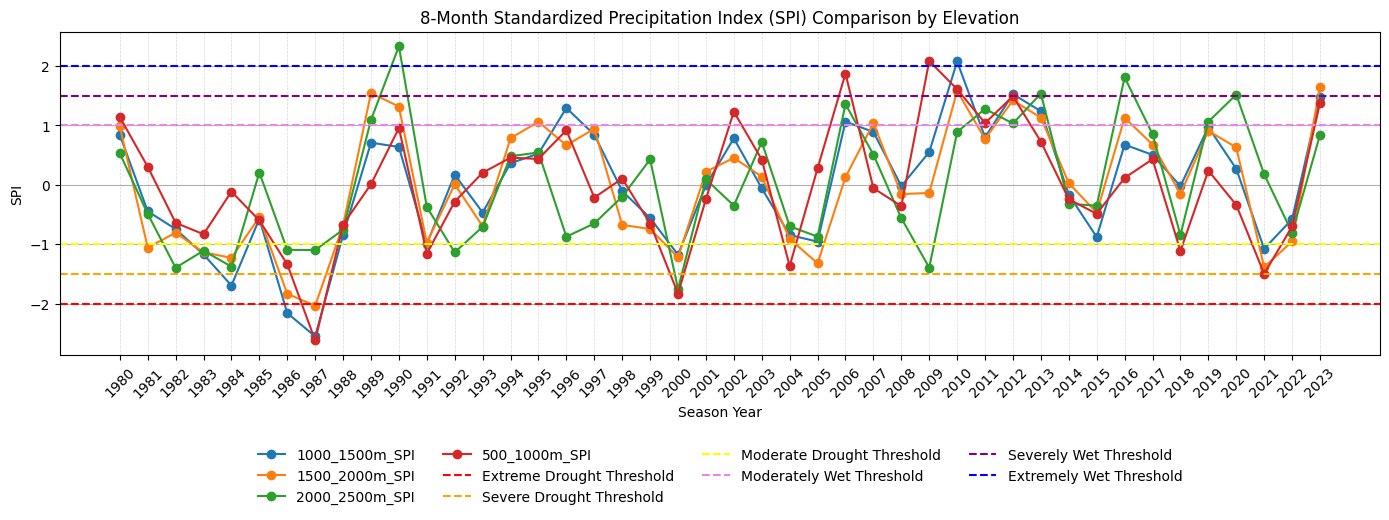

In [72]:
# Plot all SPI columns from spi_df on the same graph for comparison
plt.figure(figsize=(14, 6))
# choose x-axis: prefer 'Season_year' column if present, otherwise use the DataFrame index
if 'Season_year' in spi_df.columns and not np.issubdtype(spi_df.index.dtype, np.number):
    x = spi_df['Season_year']
else:
    x = spi_df.index

# select numeric SPI columns (exclude Season_year)
cols = [c for c in spi_df.columns if c != 'Season_year' and np.issubdtype(spi_df[c].dtype, np.number)]

cmap = plt.get_cmap('tab10')
for i, col in enumerate(cols):
    plt.plot(x, spi_df[col], marker='o', label=col, color=cmap(i % 10), lw=1.5)

# Add thresholds for drought classifications
plt.axhline(-2.0, color='r', linestyle='--', label='Extreme Drought Threshold')
plt.axhline(-1.5, color='orange', linestyle='--', label='Severe Drought Threshold')
plt.axhline(-1.0, color='yellow', linestyle='--', label='Moderate Drought Threshold')
plt.axhline(1.0, color='violet', linestyle='--', label='Moderately Wet Threshold')
plt.axhline(1.5, color='purple', linestyle='--', label='Severely Wet Threshold')
plt.axhline(2.0, color='blue', linestyle='--', label='Extremely Wet Threshold')

plt.xlabel('Season Year')
plt.ylabel('SPI')
plt.title('8-Month Standardized Precipitation Index (SPI) Comparison by Elevation')
plt.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.5, -0.50), frameon=False)
plt.grid(True, axis='y')
for year in spi_df.index:
    plt.axvline(x=year, color='gray', linestyle='--', linewidth=0.5, alpha=0.3)
plt.xticks(ticks=range(len(spi_df)), labels=spi_df['Season_year'].astype(str).values, rotation=45)
out_path = config['plots'] / 'SPI_8.png'
plt.tight_layout()
plt.savefig(out_path, dpi=150)
print(f"Saved monthly SWEI plot for 2023 to: {out_path}")
plt.show()

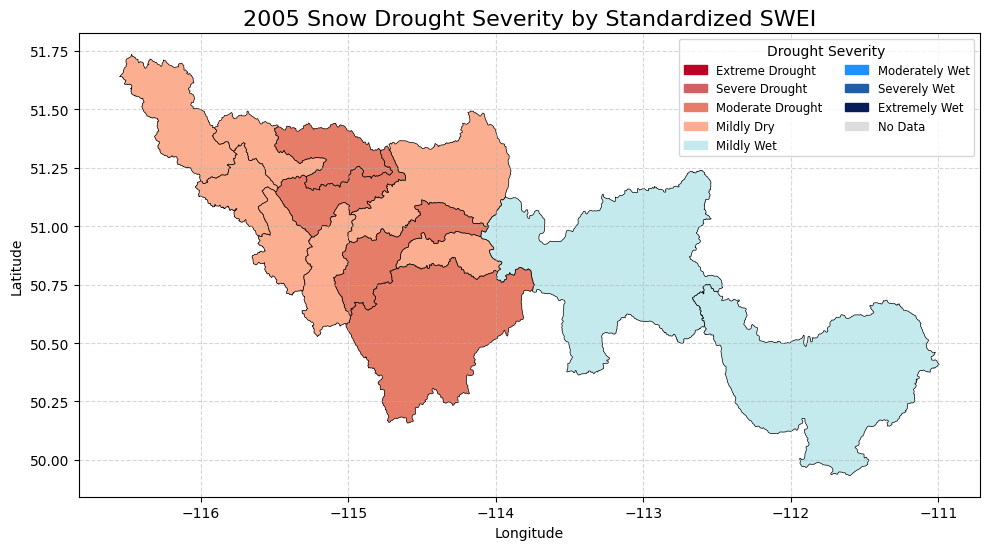

In [ ]:
# Filter onset_to_peak for the year 2005
onset_to_peak_2005 = spi_df[spi_df['Season_year'] == 2005]

# Get the classification for 2005 from plot_data
classifications_2005 = spi_df[spi_df['Season_year'] == 2005][[
    '1000_1500m_Classification', '1500_2000m_Classification', '2000_2500m_Classification', '500_1000m_Classification'
]].iloc[0]

# Map elevation category to classification
elev_class_map = {
    '1000_1500m': classifications_2005['1000_1500m_Classification'],
    '1500_2000m': classifications_2005['1500_2000m_Classification'],
    '2000_2500m': classifications_2005['2000_2500m_Classification'],
    '500_1000m': classifications_2005['500_1000m_Classification'],
}
# open Bow Basin shapefile
bow_basin = gpd.read_file(config['shapefile_dir'])

# Add drought classification to the Bow Basin shapefile
bow_basin['Drought_Classification'] = bow_basin['elev_class'].map(elev_class_map)

# Add drought classification to onset_to_peak_2005
onset_to_peak_2005 = onset_to_peak_2005.copy()

# detect elevation-category columns (use elev_order if present, otherwise fall back to desired_order)
elev_ref = globals().get('elev_order', None)
if elev_ref is None:
    elev_ref = globals().get('desired_order', ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m'])

elev_cols = [c for c in onset_to_peak_2005.columns if c in elev_ref]

# if the DF is wide (columns per elevation) -> melt to long and map
if elev_cols and 'Elevation_Category' not in onset_to_peak_2005.columns:
    onset_to_peak_2005 = (
        onset_to_peak_2005.reset_index(drop=True)
        .melt(id_vars=['season_year'], value_vars=elev_cols,
              var_name='Elevation_Category', value_name='SSWEI')
    )
    onset_to_peak_2005['Drought_Classification'] = onset_to_peak_2005['Elevation_Category'].map(elev_class_map)
else:
    # if already long / has Elevation_Category column, map directly
    onset_to_peak_2005['Drought_Classification'] = onset_to_peak_2005['Elevation_Category'].map(elev_class_map)

# Define a color map for drought severity
severity_colors_SPI = {
    'Extreme Drought': '#BD0026',
    'Severe Drought': '#D45F61',
    'Moderate Drought': '#E67D68',
    'Mildly Dry': '#FCAE91',
    'Mildly Wet': "#C4EAEE",
    'Moderately Wet': '#1E90FF',
    'Severely Wet': '#225EA8',
    'Extremely Wet': '#081D58',
    'No Data': '#dddddd'
}

# Assign colors to each polygon based on drought classification (fill missing with light gray)
bow_basin['color'] = bow_basin['Drought_Classification'].map(severity_colors_SPI).fillna('#dddddd')

# Plot the Bow Basin colored by drought severity
fig, ax = plt.subplots(figsize=(10, 8))
bow_basin.plot(ax=ax, color=bow_basin['color'], edgecolor='black', linewidth=0.5)

# Create a full legend showing all severity categories (even if not present on the map)
legend_order = list(severity_colors_SPI.keys())
legend_patches = [mpatches.Patch(color=severity_colors_SPI[k], label=k) for k in legend_order]

# Place the legend; use multiple columns to keep it compact
plt.legend(handles=legend_patches, title='Drought Severity', loc='upper right',
           bbox_to_anchor=(1.00, 1.00), ncol=2, fontsize='small', frameon=True)

plt.title('2005 Snow Drought Severity by Standardized SWEI', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save to an existing path in config (use 'plots' to avoid missing key)
outpath = config.get('plots', config.get('output_dir'))
plt.savefig(Path(outpath) / 'bow_basin_drought_severity_2005.png', dpi=150)
plt.show()

Saved SPI severity map to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\bow_basin_SPI_severity_2005.png


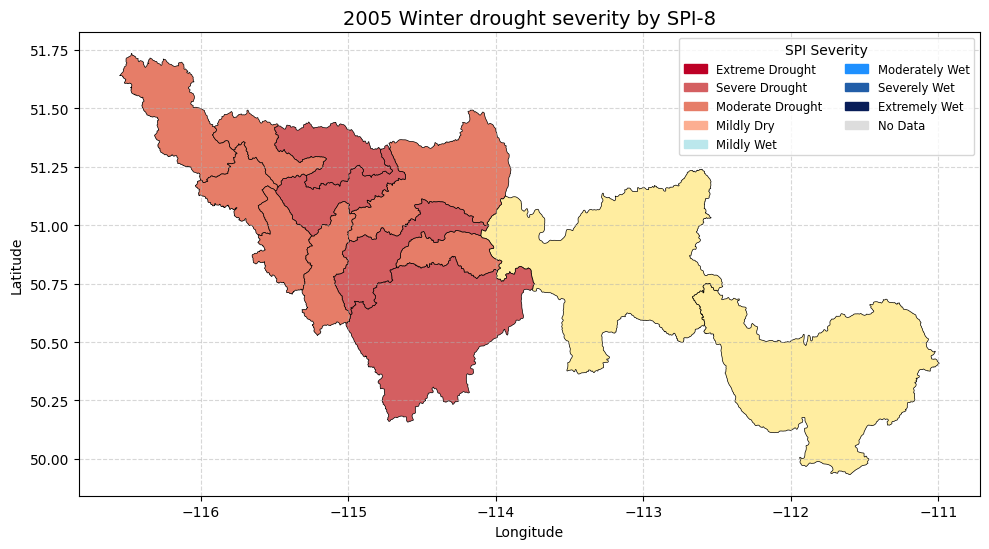

In [88]:
# Filter SPI for 2005 and plot drought severity on Bow Basin
# Assumes spi_df, config, sswei, and (optionally) bow_basin, severity_colors already exist in the notebook.

# Ensure bow_basin is available
if 'bow_basin' not in globals():
    bow_basin = gpd.read_file(config['shapefile_dir'])

# get SPI row for season 2005
season = 2005
if season in spi_df.index:
    spi_2005 = spi_df.loc[season]
else:
    # if index is not integer-indexed, try to find by value in index column
    try:
        spi_2005 = spi_df.reset_index().query("Season_year == @season").set_index('Season_year').loc[season].squeeze()
    except Exception:
        raise KeyError(f"SPI for season {season} not found in spi_df")

# prepare elevation -> SPI and classification maps
elevations = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
elev_spi_map = {}
elev_class_map = {}
for elev in elevations:
    col = f"{elev}_SPI"
    val = spi_2005[col] if col in spi_2005.index else (spi_2005[col] if isinstance(spi_2005, pd.Series) and col in spi_2005.index else np.nan)
    try:
        val = float(val)
    except Exception:
        val = np.nan
    elev_spi_map[elev] = val
    elev_class_map[elev] = sswei.classify_drought(val) if not np.isnan(val) else None

# add numeric SPI and classification to shapefile using its elevation field (assumed 'elev_class')
bow_basin = bow_basin.copy()
bow_basin['SPI_2005'] = bow_basin['elev_class'].map(elev_spi_map)
bow_basin['SPI_2005_Class'] = bow_basin['elev_class'].map(elev_class_map)

# severity color map (use existing if available)

# Define a color map that matches the SPI classification labels produced earlier in the notebook.
# Include a 'No Data' entry and allow fallback to the general severity_colors if needed.
severity_colors_SPI = {
    'Extreme Drought': '#BD0026',
    'Severe Drought': '#D45F61',
    'Moderate Drought': '#E67D68',
    'Mildly Dry': '#FCAE91',
    'Mildly Wet': "#BBE7EC",
    'Moderately Wet': '#1E90FF',
    'Severely Wet': '#225EA8',
    'Extremely Wet': '#081D58',
    'No Data': '#dddddd'
}

# Map classification -> color using the SPI-specific map, fallback to existing severity_colors (if present),
# and finally to a neutral color.
bow_basin['color'] = bow_basin['SPI_2005_Class'].map(lambda x: severity_colors_SPI.get(x) or severity_colors.get(x) or '#dddddd')

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
bow_basin.plot(ax=ax, color=bow_basin['color'], edgecolor='black', linewidth=0.5)

# Create legend from the SPI color mapping (keep order stable)
legend_order = list(severity_colors_SPI.keys())
legend_patches = [mpatches.Patch(color=severity_colors_SPI[k], label=k) for k in legend_order]
plt.legend(handles=legend_patches, title='SPI Severity', loc='upper right',
           bbox_to_anchor=(1.00, 1.00), ncol=2, fontsize='small', frameon=True)

plt.title(f'2005 Winter drought severity by SPI-8', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

out_file = config['plots'] / f'bow_basin_SPI_severity_{season}.png'
fig.savefig(out_file, dpi=150)
print(f"Saved SPI severity map to: {out_file}")
plt.show()

# Comparison

In [105]:
SWEI = pd.read_csv(config['output_dir'] / 'SWEI_final.csv')
SPI = pd.read_csv(config['output_dir'] / 'SPI_final.csv')
SnoDRI = pd.read_csv(config['output_dir'] / 'SnoDRI_final.csv')

# rename season_year column to Season_year for merging
SWEI = SWEI.rename(columns={'season_year': 'Season_year'})
SPI = SPI.rename(columns={'season_year': 'Season_year'})
SnoDRI = SnoDRI.rename(columns={'season_year': 'Season_year'})

# Merge the three DataFrames on 'Season_year'
comparison_df = SWEI.merge(SPI, on='Season_year', how='outer').merge(SnoDRI, on='Season_year', how='outer')
comparison_df = comparison_df.sort_values(by='Season_year').reset_index(drop=True)

# drop classification columns
cols_to_drop = [col for col in comparison_df.columns if 'Classification' in col]
#drop unnamed index column if present
if 'Unnamed: 0' in comparison_df.columns:
    cols_to_drop.append('Unnamed: 0')
comparison_df = comparison_df.drop(columns=cols_to_drop)
display(comparison_df)

Season_year  1000_1500m  1500_2000m  2000_2500m  500_1000m  \
0          1980   -0.778473   -0.630553   -0.346771  -0.087648   
1          1981    0.320094   -0.022423    0.090731   0.605933   
2          1982   -0.942805   -0.050002    0.072459   0.618429   
3          1983   -0.358285   -0.266688   -0.307029   0.474398   
4          1984   -0.147442    0.176385   -0.214268   0.994070   
5          1985    0.314323    0.575974    0.860058   1.250473   
6          1986   -0.474813    0.062905    0.006162   0.569811   
7          1987   -1.338402   -0.326762   -0.616191   0.386472   
8          1988    0.898300    1.037102    0.378059   1.295822   
9          1989    0.113604    1.057718    1.412421   1.065104   
10         1990    0.384277    0.525592    1.441223   1.063012   
11         1991   -1.025095   -0.872029   -0.281262   0.178793   
12         1992    0.128423    0.557087    0.702379  -0.112291   
13         1993   -0.646726   -0.731340    0.200341  -0.138141   
14         1994   -1.504528   -0.755319    0.717341  -1.172698   
15         1995    0.707409    0.748076    1.777195   0.869234   
16         1996    2.178327    1.192694   -0.660233   0.715317   
17         1997    0.040717   -0.233249   -1.799359  -0.909382   
18         1998   -1.492368   -1.730490   -0.956007  -0.781910   
19         1999    0.212645   -0.246122    0.277769  -0.392698   
20         2000   -0.678681   -0.832356   -0.850948  -1.830365   
21         2001    1.137237    0.446486    0.091664  -0.025148   
22         2002    0.282187   -0.577384   -1.271441  -0.195214   
23         2003    0.595247    0.265714   -0.016152   0.371172   
24         2004   -0.954213   -1.681748   -1.682305  -0.931091   
25         2005   -1.565234   -1.873826   -1.543537  -1.658868   
26         2006   -0.257130   -0.973809   -0.399014  -0.745476   
27         2007   -0.628687   -0.537380   -0.454121  -0.375278   
28         2008    1.231075    0.833027    0.051636   0.715045   
29         2009    0.441938   -0.111181   -0.786769   0.040478   
30         2010    1.579645    1.361116    0.396905   1.273736   
31         2011   -0.935265   -1.066246   -0.620346  -0.955700   
32         2012    0.936063    0.361640   -0.014987   0.294187   
33         2013    1.149359    1.026672    1.058171   1.152889   
34         2014   -0.264381   -0.194085   -0.238001  -0.027600   
35         2015   -1.039612   -0.601817   -0.795937  -0.960427   
36         2016    0.250616    0.358479    0.767145  -0.544861   
37         2017    1.276065    1.522590    0.945822   0.795337   
38         2018   -0.198584   -0.029837   -0.458080  -0.589183   
39         2019    0.260517    0.387468    0.701372   0.215133   
40         2020    0.073047   -0.406844    0.528803  -0.046677   
41         2021   -0.298317   -0.007346    0.722599  -1.810268   
42         2022    0.810314    1.078991    0.491963   0.022396   
43         2023    0.207614    1.183118    0.620539  -0.676320   

    1000_1500m_SPI  1500_2000m_SPI  2000_2500m_SPI  500_1000m_SPI  \
0         0.838107        0.979624        0.527859       1.137794   
1        -0.447007       -1.056778       -0.489698       0.302220   
2        -0.746335       -0.808827       -1.396826      -0.641098   
3        -1.172533       -1.136674       -1.109690      -0.833213   
4        -1.696451       -1.231230       -1.378387      -0.115584   
5        -0.574501       -0.544821        0.204682      -0.601074   
6        -2.159259       -1.834958       -1.096205      -1.337724   
7        -2.552108       -2.036559       -1.100057      -2.619651   
8        -0.846069       -0.683786       -0.757280      -0.670248   
9         0.707024        1.541569        1.090121       0.007406   
10        0.634288        1.314547        2.328817       0.952901   
11       -0.996664       -0.975804       -0.375195      -1.158591   
12        0.169139        0.006673       -1.138227      -0.285427   
13       -0.467906       -0.699433       -0.707475       0.201783  

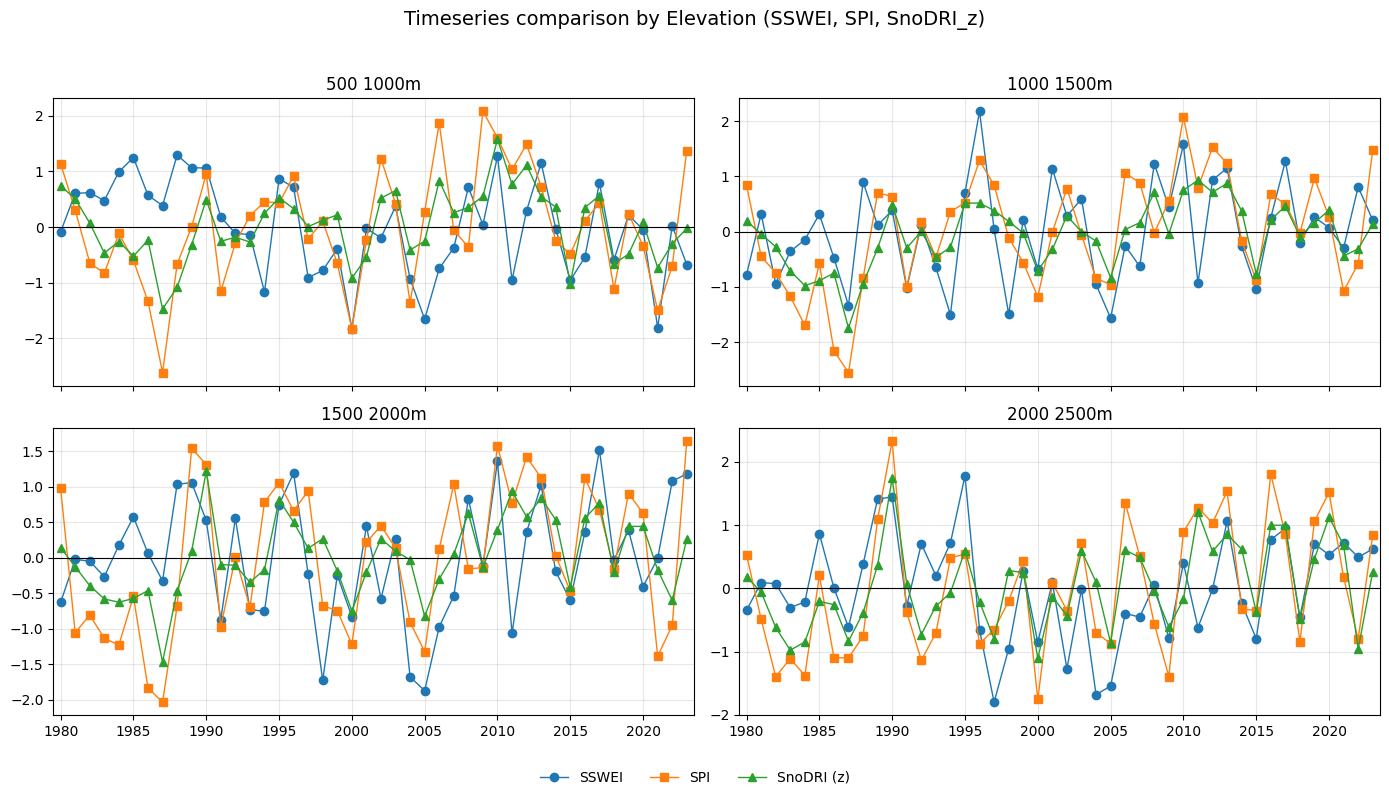

In [81]:
# Timeseries comparison per elevation (order: 500-1000, 1000-1500, 1500-2000, 2000-2500)
elev_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
n = len(elev_order)
ncols = 2
nrows = (n + 1) // 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8), sharex=True)
axes_flat = axes.flatten() if hasattr(axes, "flatten") else [axes]

x = comparison_df['Season_year']

for i, elev in enumerate(elev_order):
    ax = axes_flat[i]
    sswei_col = elev
    spi_col = f"{elev}_SPI"
    snodri_col = f"{elev}_SnoDRI_z"

    plotted = False
    if sswei_col in comparison_df.columns:
        ax.plot(x, comparison_df[sswei_col], label='SSWEI', color='#1f77b4', marker='o', lw=1)
        plotted = True
    if spi_col in comparison_df.columns:
        ax.plot(x, comparison_df[spi_col], label='SPI', color='#ff7f0e', marker='s', lw=1)
        plotted = True
    if snodri_col in comparison_df.columns:
        ax.plot(x, comparison_df[snodri_col], label='SnoDRI (z)', color='#2ca02c', marker='^', lw=1)
        plotted = True

    if not plotted:
        ax.text(0.5, 0.5, f'No data for {elev}', transform=ax.transAxes, ha='center', va='center')

    ax.set_title(elev.replace('_', ' '))
    ax.axhline(0, color='k', lw=0.8, linestyle='-')
    ax.grid(alpha=0.3)
    ax.set_xlim(x.min() - 0.5, x.max() + 0.5)

# hide any unused axes
for j in range(len(elev_order), len(axes_flat)):
    axes_flat[j].set_visible(False)

# global legend and layout
handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False)
fig.suptitle('Timeseries comparison by Elevation (SSWEI, SPI, SnoDRI_z)', fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()



In [99]:
# Normalize numeric columns to range [-1, 1] (exclude Season_year)
comparison_df = comparison_df.copy()
num_cols = comparison_df.select_dtypes(include=[np.number]).columns.tolist()
if 'Season_year' in num_cols:
    num_cols.remove('Season_year')

for col in num_cols:
    s = pd.to_numeric(comparison_df[col], errors='coerce')
    valid = s.notna()
    if not valid.any():
        comparison_df[col] = np.nan
        continue
    mn = s[valid].min()
    mx = s[valid].max()
    if np.isclose(mx, mn):
        comparison_df.loc[valid, col] = 0.0
    else:
        comparison_df.loc[valid, col] = -1.0 + 2.0 * (s[valid] - mn) / (mx - mn)

# save the normalized DataFrame
out_file = config['output_dir'] / 'Drought_Indices_Comparison_Normalized.csv'
comparison_df.to_csv(out_file, index=False)
print(f"Saved normalized drought indices comparison to: {out_file}")
print("Normalized numeric columns to [-1, 1]:", num_cols)
display(comparison_df.head())


Saved normalized drought indices comparison to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\Drought_Indices_Comparison_Normalized.csv
Normalized numeric columns to [-1, 1]: ['1000_1500m', '1500_2000m', '2000_2500m', '500_1000m', 'Unnamed: 0', '1000_1500m_SPI', '1500_2000m_SPI', '2000_2500m_SPI', '500_1000m_SPI', '1000_1500m_SnoDRI_z', '1500_2000m_SnoDRI_z', '2000_2500m_SnoDRI_z', '500_1000m_SnoDRI_z']


Season_year  1000_1500m  1500_2000m  2000_2500m  500_1000m  Unnamed: 0  \
0         1980   -0.579673   -0.267891   -0.187716   0.114915   -1.000000   
1         1981    0.007238    0.090210    0.056934   0.558639   -0.953488   
2         1982   -0.667467    0.073970    0.046716   0.566633   -0.906977   
3         1983   -0.355187   -0.053627   -0.165493   0.474488   -0.860465   
4         1984   -0.242544    0.207279   -0.113621   0.806952   -0.813953   

   1000_1500m_SPI  1500_2000m_SPI  2000_2500m_SPI  500_1000m_SPI  \
0        0.466220        0.637528        0.118003       0.598517   
1       -0.089574       -0.468063       -0.380334       0.243041   
2       -0.219029       -0.333447       -0.824588      -0.158271   
3       -0.403353       -0.511440       -0.683967      -0.240002   
4       -0.629940       -0.562776       -0.815558       0.065297   

   1000_1500m_SnoDRI_z  1500_2000m_SnoDRI_z  2000_2500m_SnoDRI_z  \
0             0.448378             0.197746            -0.096853   
1             0.274152            -0.002024            -0.263444   
2             0.099331            -0.199253            -0.657686   
3            -0.224883            -0.338978            -0.909656   
4            -0.424800            -0.373677            -0.819502   

   500_1000m_SnoDRI_z  
0            0.450855  
1            0.296234  
2            0.012168  
3           -0.340578  
4           -0.205358

In [112]:
# Normalize numeric columns to range [-1, 1] using fixed min=-3 and max=3
vmin, vmax = -3.0, 3.0

def normalize_fixed(df, exclude_cols=None, vmin=-3.0, vmax=3.0):
    if exclude_cols is None:
        exclude_cols = ['Season_year', 'month', 'month_label']
    df = df.copy()
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in exclude_cols]
    for c in num_cols:
        s = pd.to_numeric(df[c], errors='coerce')
        clipped = s.clip(vmin, vmax)
        # map [vmin, vmax] -> [-1, 1]
        if vmax == vmin:
            norm = pd.Series(np.nan, index=df.index)
        else:
            norm = -1.0 + 2.0 * (clipped - vmin) / (vmax - vmin)
        df[f'{c}_fixednorm'] = norm
    return df

outputs = {}

if 'comparison_df' in globals():
    comparison_df_fixed = normalize_fixed(comparison_df, exclude_cols=['Season_year'])
    out = config['output_dir'] / 'Drought_Indices_Comparison_fixednorm.csv'
    comparison_df_fixed.to_csv(out, index=False)
    outputs['comparison_df'] = out

if 'merged_2005_norm' in globals():
    merged_2005_norm_fixed = normalize_fixed(merged_2005_norm, exclude_cols=['month'])
    out = config['plots'] / 'merged_2005_norm_fixed.csv'
    merged_2005_norm_fixed.to_csv(out, index=False)
    outputs['merged_2005_norm'] = out

if 'merged_unstacked_norm' in globals():
    merged_unstacked_norm_fixed = normalize_fixed(merged_unstacked_norm)
    out = config['output_dir'] / 'merged_unstacked_normalized_fixed.csv'
    merged_unstacked_norm_fixed.to_csv(out, index=False)
    outputs['merged_unstacked_norm'] = out

if 'merged_2005' in globals():
    merged_2005_fixed = normalize_fixed(merged_2005, exclude_cols=['month'])
    out = config['plots'] / 'merged_2005_fixednorm.csv'
    merged_2005_fixed.to_csv(out, index=False)
    outputs['merged_2005'] = out

# Optionally update monthly_spi_2005 if present
if 'monthly_spi_2005' in globals():
    monthly_spi_2005_fixed = normalize_fixed(monthly_spi_2005, exclude_cols=['Season_year', 'month'])
    out = config['output_dir'] / 'monthly_SPI_2005_fixednorm.csv'
    monthly_spi_2005_fixed.to_csv(out, index=False)
    outputs['monthly_spi_2005'] = out

# Report saved files
for k, p in outputs.items():
    print(f"Saved fixed-norm ({vmin},{vmax}) for {k} to: {p}")

# keep newly created variables in the notebook namespace for inspection
if 'comparison_df_fixed' in globals():
    display(comparison_df_fixed.head())

Saved fixed-norm (-3.0,3.0) for comparison_df to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\Drought_Indices_Comparison_fixednorm.csv
Saved fixed-norm (-3.0,3.0) for merged_2005_norm to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\merged_2005_norm_fixed.csv
Saved fixed-norm (-3.0,3.0) for merged_2005 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\merged_2005_fixednorm.csv


Season_year  1000_1500m  1500_2000m  2000_2500m  500_1000m  1000_1500m_SPI  \
0         1980   -0.778473   -0.630553   -0.346771  -0.087648        0.838107   
1         1981    0.320094   -0.022423    0.090731   0.605933       -0.447007   
2         1982   -0.942805   -0.050002    0.072459   0.618429       -0.746335   
3         1983   -0.358285   -0.266688   -0.307029   0.474398       -1.172533   
4         1984   -0.147442    0.176385   -0.214268   0.994070       -1.696451   

   1500_2000m_SPI  2000_2500m_SPI  500_1000m_SPI  1000_1500m_SnoDRI_z  ...  \
0        0.979624        0.527859       1.137794             0.192867  ...   
1       -1.056778       -0.489698       0.302220            -0.040626  ...   
2       -0.808827       -1.396826      -0.641098            -0.274917  ...   
3       -1.136674       -1.109690      -0.833213            -0.709422  ...   
4       -1.231230       -1.378387      -0.115584            -0.977346  ...   

   2000_2500m_fixednorm  500_1000m_fixednorm  1000_1500m_SPI_fixednorm  \
0             -0.115590            -0.029216                  0.279369   
1              0.030244             0.201978                 -0.149002   
2              0.024153             0.206143                 -0.248778   
3             -0.102343             0.158133                 -0.390844   
4             -0.071423             0.331357                 -0.565484   

   1500_2000m_SPI_fixednorm  2000_2500m_SPI_fixednorm  \
0                  0.326541                  0.175953   
1                 -0.352259                 -0.163233   
2                 -0.269609                 -0.465609   
3                 -0.378891                 -0.369897   
4                 -0.410410                 -0.459462   

   500_1000m_SPI_fixednorm  1000_1500m_SnoDRI_z_fixednorm  \
0                 0.379265                       0.064289   
1                 0.100740                      -0.013542   
2                -0.213699                      -0.091639   
3                -0.277738                      -0.236474   
4                -0.038528                      -0.325782   

   1500_2000m_SnoDRI_z_fixednorm  2000_2500m_SnoDRI_z_fixednorm  \
0                       0.047189                       0.059625   
1                      -0.042463                      -0.019392   
2                      -0.130973                      -0.206388   
3                      -0.193678                      -0.325902   
4                      -0.209250                      -0.283140   

   500_1000m_SnoDRI_z_fixednorm  
0                      0.247622  
1                      0.168790  
2                      0.023961  
3                     -0.155885  
4                     -0.086944  

[5 rows x 25 columns]

Saved comparison timeseries figure to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\comparison_timeseries_by_elevation.png


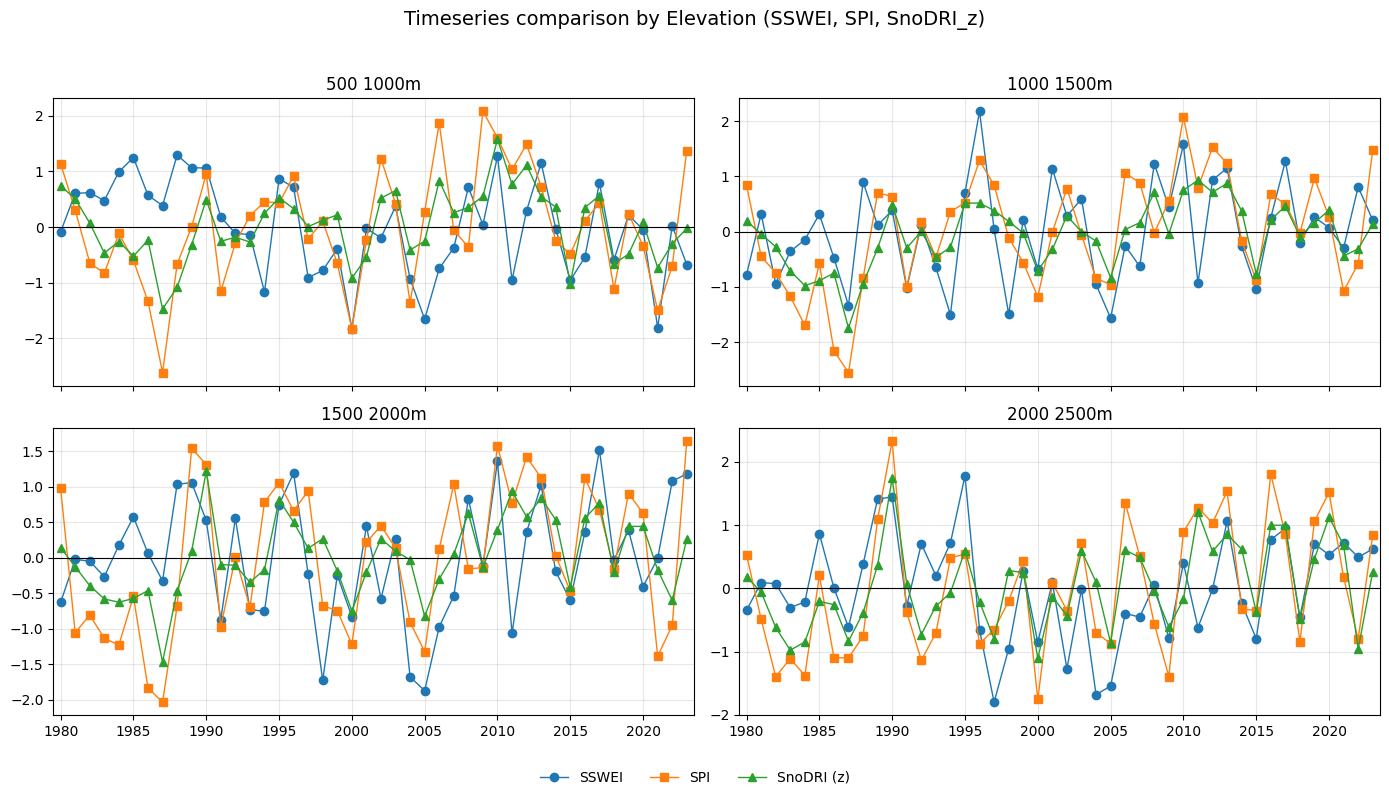

In [113]:
# Timeseries comparison per elevation (order: 500-1000, 1000-1500, 1500-2000, 2000-2500)
elev_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']
n = len(elev_order)
ncols = 2
nrows = (n + 1) // 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 8), sharex=True)
axes_flat = axes.flatten() if hasattr(axes, "flatten") else [axes]

x = comparison_df_fixed['Season_year']

for i, elev in enumerate(elev_order):
    ax = axes_flat[i]
    sswei_col = elev
    spi_col = f"{elev}_SPI"
    snodri_col = f"{elev}_SnoDRI_z"

    plotted = False
    if sswei_col in comparison_df_fixed.columns:
        ax.plot(x, comparison_df_fixed[sswei_col], label='SSWEI', color='#1f77b4', marker='o', lw=1)
        plotted = True
    if spi_col in comparison_df_fixed.columns:
        ax.plot(x, comparison_df_fixed[spi_col], label='SPI', color='#ff7f0e', marker='s', lw=1)
        plotted = True
    if snodri_col in comparison_df_fixed.columns:
        ax.plot(x, comparison_df_fixed[snodri_col], label='SnoDRI (z)', color='#2ca02c', marker='^', lw=1)
        plotted = True

    if not plotted:
        ax.text(0.5, 0.5, f'No data for {elev}', transform=ax.transAxes, ha='center', va='center')

    ax.set_title(elev.replace('_', ' '))
    ax.axhline(0, color='k', lw=0.8, linestyle='-')
    ax.grid(alpha=0.3)
    ax.set_xlim(x.min() - 0.5, x.max() + 0.5)

# hide any unused axes
for j in range(len(elev_order), len(axes_flat)):
    axes_flat[j].set_visible(False)

# global legend and layout
handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False)
fig.suptitle('Timeseries comparison by Elevation (SSWEI, SPI, SnoDRI_z)', fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])

out_file = config['plots'] / 'comparison_timeseries_by_elevation.png'
fig.savefig(out_file, dpi=150)
print(f"Saved comparison timeseries figure to: {out_file}")
plt.show()

In [84]:
# Load and filter SWEI, SPI, SnoDRI CSVs for season 2005, then save/display the filtered subsets.
paths = {
    'SWEI': config['output_dir'] / 'monthly_SWEI_2005_long.csv',
    'SPI':  config['output_dir'] / 'monthly_SPI_2005.csv',
    'SnoDRI': config['output_dir'] / 'sel_season_2005.csv'
}

SWEI_2005 = pd.read_csv(paths['SWEI'])
SPI_2005 = pd.read_csv(paths['SPI'])
SnoDRI_2005 = pd.read_csv(paths['SnoDRI'])
# Display and save each filtered DataFrame
for name, df in zip(['SWEI', 'SPI', 'SnoDRI'], [SWEI_2005, SPI_2005, SnoDRI_2005]):
    print(f"\n{name} for season 2005:")
    display(df.head())
   


SWEI for season 2005:


month  1000_1500m  1500_2000m  2000_2500m  500_1000m
0      1   -0.082649   -0.070957    0.245064   0.417232
1      2    0.627864    0.169559    0.427731   0.429899
2      3    1.463092    1.422198    1.456277   1.478063
3      4   -0.618158   -0.341891    0.558838  -0.767177
4      5   -1.409226   -1.219167   -0.925401  -1.353153


SPI for season 2005:


Season_year Elevation_Category  month month_label  Precipitation       SPI
0         2005         1000_1500m     10         Oct      19.361433 -0.052669
1         2005         1000_1500m     11         Nov      16.813028  0.131721
2         2005         1000_1500m     12         Dec       4.272242 -1.209708
3         2005         1000_1500m      1         Jan       7.627983 -0.349224
4         2005         1000_1500m      2         Feb      16.604584  0.466405


SnoDRI for season 2005:


season_year   month_end Elevation_Category    SnoDRI  SnoDRI_z
0         2005  2005-10-31         1000_1500m -0.457809 -0.115257
1         2005  2005-10-31          500_1000m  1.208294  0.290900
2         2005  2005-10-31         1500_2000m -0.270302 -0.069547
3         2005  2005-10-31         2000_2500m -1.798193 -0.442011
4         2005  2005-11-30         1000_1500m -3.321122 -0.813266

In [86]:
# Unstack SPI for 2005 by elevation and drop Precipitation
#if 'spi_2005_aligned' not in globals():
   # raise NameError("spi_2005_aligned not found. Run the previous cells that create it first.")

df = SPI_2005.copy()

# drop precipitation column if present
if 'Precipitation' in df.columns:
    df = df.drop(columns=['Precipitation'])

# choose month_label column (prefer month_label_spi if present)
month_label_col = 'month_label_spi' if 'month_label_spi' in df.columns else 'month_label'
index_cols = ['Season_year', 'month', month_label_col]

# pivot to wide format: one SPI column per Elevation_Category
spi_2005_unstacked = df.pivot_table(index=index_cols, columns='Elevation_Category', values='SPI', aggfunc='first')

# flatten columns to e.g. "2000_2500m_SPI"
spi_2005_unstacked.columns = [f"{c}_SPI" for c in spi_2005_unstacked.columns]

# reset index for easy viewing/saving and order months Oct->May
spi_2005_unstacked = spi_2005_unstacked.reset_index()
months_order = [10, 11, 12, 1, 2, 3, 4, 5]
spi_2005_unstacked['month'] = spi_2005_unstacked['month'].astype(int)
# create ordering key so Oct->May sorts correctly within the season
spi_2005_unstacked['month_order'] = spi_2005_unstacked['month'].apply(lambda m: months_order.index(m) if m in months_order else 999)
spi_2005_unstacked = spi_2005_unstacked.sort_values(['Season_year', 'month_order']).drop(columns=['month_order','Season_year', 'month_label'])

# save and display
out_file = config['output_dir'] / 'monthly_SPI_2005_unstacked.csv'
spi_2005_unstacked.to_csv(out_file, index=False)
print(f"Saved unstacked monthly SPI for 2005 to: {out_file}")

display(spi_2005_unstacked.head(12))

Saved unstacked monthly SPI for 2005 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SPI_2005_unstacked.csv


month  1000_1500m_SPI  1500_2000m_SPI  2000_2500m_SPI  500_1000m_SPI
5     10       -0.052669       -0.013912        0.549937       0.393079
6     11        0.131721        0.276616       -0.712863      -0.074196
7     12       -1.209708       -1.036021       -1.424022      -0.908139
0      1       -0.349224       -0.382049        0.390312       0.233379
1      2        0.466405        0.035853       -0.213536       0.368217
2      3       -0.891061       -1.640496       -0.784207       0.422021
3      4       -0.159193       -0.427991        0.554801       0.658789
4      5       -0.376534       -0.464000       -0.473230       0.435772

In [90]:

df = SnoDRI_2005.copy()


# derive month & month_label from month_end if available, otherwise try other date-like columns
if 'month_end' in df.columns:
    df['month_end'] = pd.to_datetime(df['month_end'], errors='coerce')
    df['month'] = df['month_end'].dt.month
    df['month_label'] = df['month_end'].dt.strftime('%b')
else:
    # if month already present but no label, create label
    if 'month' in df.columns and 'month_label' not in df.columns:
        df['month_label'] = df['month'].apply(lambda m: pd.to_datetime(f'2000-{int(m):02d}-01').strftime('%b') if pd.notna(m) else np.nan)
    # try to infer month from any date-like column
    if 'month' not in df.columns:
        for c in df.columns:
            parsed = pd.to_datetime(df[c], errors='coerce')
            if parsed.notna().sum() > 0:
                df['month'] = parsed.dt.month
                df['month_label'] = parsed.dt.strftime('%b')
                break

index_cols = ['season_year', 'month', 'month_label']

# pivot to wide format: one SPI column per Elevation_Category
snodri_2005_unstacked = df.pivot_table(index=index_cols, columns='Elevation_Category', values='SnoDRI_z', aggfunc='first')

# flatten columns to e.g. "2000_2500m_SPI"
snodri_2005_unstacked.columns = [f"{c}_SnoDRI" for c in snodri_2005_unstacked.columns]

# reset index for easy viewing/saving and order months Oct->May
snodri_2005_unstacked = snodri_2005_unstacked.reset_index()
months_order = [10, 11, 12, 1, 2, 3, 4, 5]
snodri_2005_unstacked['month'] = snodri_2005_unstacked['month'].astype(int)
# create ordering key so Oct->May sorts correctly within the season
snodri_2005_unstacked['month_order'] = snodri_2005_unstacked['month'].apply(lambda m: months_order.index(m) if m in months_order else 999)
snodri_2005_unstacked = snodri_2005_unstacked.sort_values(['season_year', 'month_order']).drop(columns=['month_order','season_year', 'month_label'])

# save and display
out_file = config['output_dir'] / 'monthly_SnoDRI_2005_unstacked.csv'
snodri_2005_unstacked.to_csv(out_file, index=False)
print(f"Saved unstacked monthly SnoDRI for 2005 to: {out_file}")
display(snodri_2005_unstacked.head(12))

Saved unstacked monthly SnoDRI for 2005 to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\monthly_SnoDRI_2005_unstacked.csv


month  1000_1500m_SnoDRI  1500_2000m_SnoDRI  2000_2500m_SnoDRI  \
5     10          -0.115257          -0.069547          -0.442011   
6     11          -0.813266          -0.493289          -1.002818   
7     12          -1.319670          -1.064800          -1.548815   
0      1          -1.560030          -1.309877          -1.194094   
1      2          -1.733270          -1.635242          -1.514538   
2      3          -1.222573          -1.564547          -1.140520   
3      4          -0.419585          -0.697759          -0.351740   
4      5           0.514175           0.246189           0.280825   

   500_1000m_SnoDRI  
5          0.290900  
6         -0.851282  
7         -1.061381  
0         -0.645319  
1         -1.579057  
2         -0.390085  
3          0.677528  
4          1.513291

In [91]:
#merge SWEI_2005, unstacked SPI and SnoDRI for 2005
merged_2005 = SWEI_2005.merge(spi_2005_unstacked, left_on=[ 'month'], right_on=[ 'month'], how='outer')
merged_2005 = merged_2005.merge(snodri_2005_unstacked, left_on=[ 'month'], right_on=[ 'month'], how='outer')
merged_2005 = merged_2005.sort_values(by='month').reset_index(drop=True)
display(merged_2005)

month  1000_1500m  1500_2000m  2000_2500m  500_1000m  1000_1500m_SPI  \
0      1   -0.082649   -0.070957    0.245064   0.417232       -0.349224   
1      2    0.627864    0.169559    0.427731   0.429899        0.466405   
2      3    1.463092    1.422198    1.456277   1.478063       -0.891061   
3      4   -0.618158   -0.341891    0.558838  -0.767177       -0.159193   
4      5   -1.409226   -1.219167   -0.925401  -1.353153       -0.376534   
5     10   -0.807238   -0.929162   -1.275402  -0.714291       -0.052669   
6     11    0.104382    0.099932   -0.524131  -0.149433        0.131721   
7     12    0.721932    0.869488    0.037024   0.658860       -1.209708   

   1500_2000m_SPI  2000_2500m_SPI  500_1000m_SPI  1000_1500m_SnoDRI  \
0       -0.382049        0.390312       0.233379          -1.560030   
1        0.035853       -0.213536       0.368217          -1.733270   
2       -1.640496       -0.784207       0.422021          -1.222573   
3       -0.427991        0.554801       0.658789          -0.419585   
4       -0.464000       -0.473230       0.435772           0.514175   
5       -0.013912        0.549937       0.393079          -0.115257   
6        0.276616       -0.712863      -0.074196          -0.813266   
7       -1.036021       -1.424022      -0.908139          -1.319670   

   1500_2000m_SnoDRI  2000_2500m_SnoDRI  500_1000m_SnoDRI  
0          -1.309877          -1.194094         -0.645319  
1          -1.635242          -1.514538         -1.579057  
2          -1.564547          -1.140520         -0.390085  
3          -0.697759          -0.351740          0.677528  
4           0.246189           0.280825          1.513291  
5          -0.069547          -0.442011          0.290900  
6          -0.493289          -1.002818         -0.851282  
7          -1.064800          -1.548815         -1.061381

2025-11-11 11:01:44,883 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 11:01:44,884 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 11:01:44,886 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 11:01:44,886 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 11:01:44,888 - INFO - Using categorical units to plot a list of strings that are all parsable as 

Saved figure to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\merged_2005_by_elevation_oct_may_raw.png


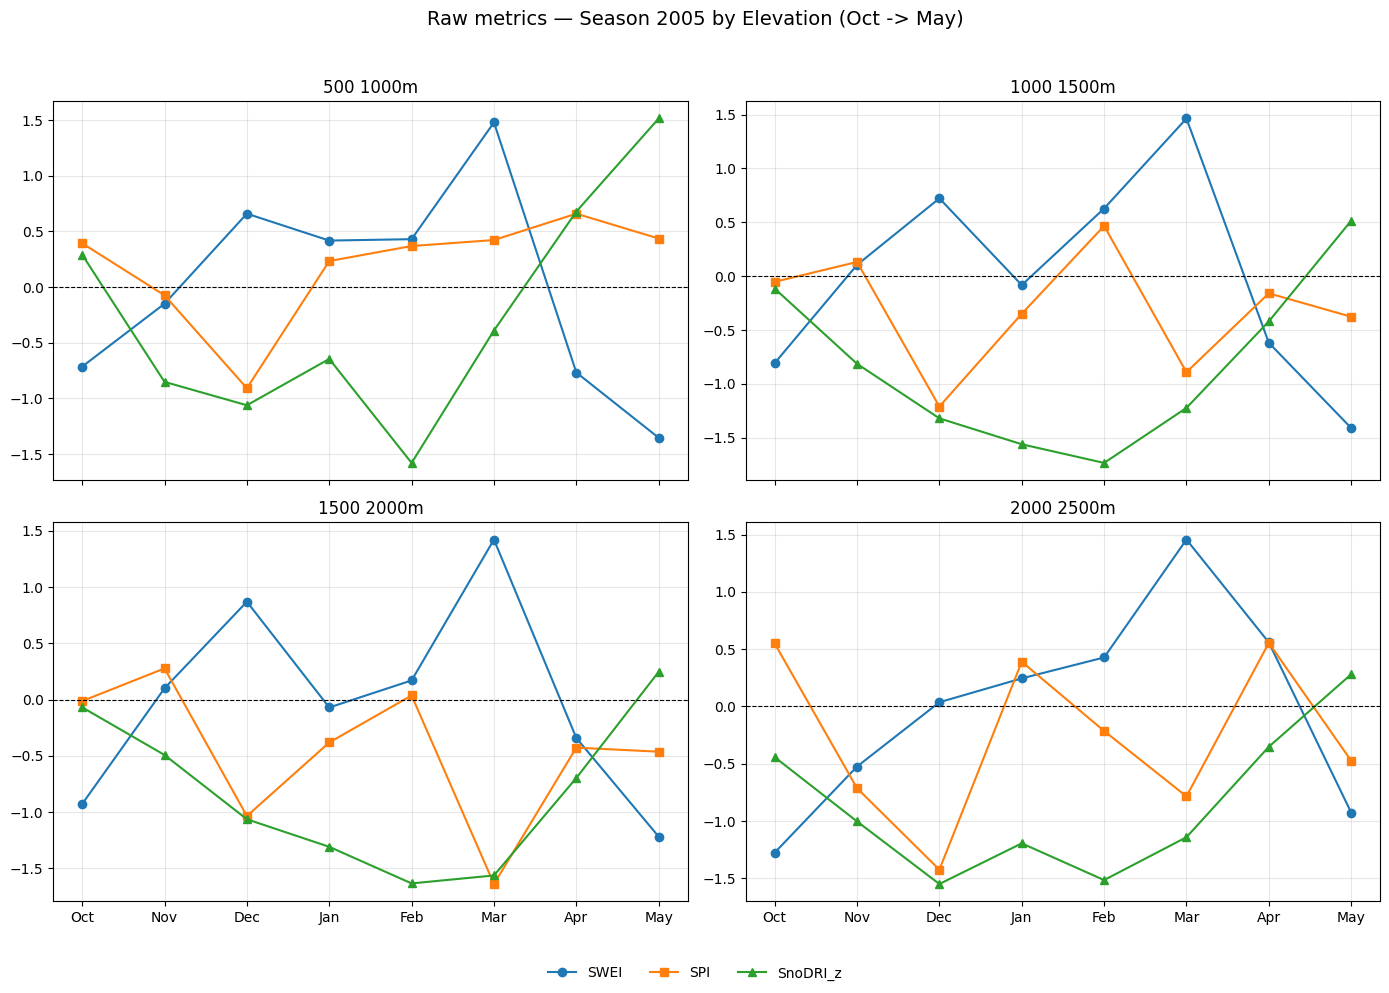

In [94]:
# Plot merged_2005 (raw values) — 4 subplots (one per elevation) showing Oct->May
if 'merged_2005' not in globals():
    raise NameError("merged_2005 not found. Run the cell that creates it first.")

month_order = [10, 11, 12, 1, 2, 3, 4, 5]
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
elev_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

color_map = {'SWEI': '#1f77b4', 'SPI': '#ff7f0e', 'SnoDRI_z': '#2ca02c'}
marker_map = {'SWEI': 'o', 'SPI': 's', 'SnoDRI_z': '^'}

def fetch_series_raw(df, elev, metric):
    # Wide-name candidates for common conventions
    wide_candidates = []
    if metric == 'SWEI':
        wide_candidates += [f"{elev}", f"{elev}_SWEI", f"{elev}_SSWEI", "SSWEI"]
    elif metric == 'SPI':
        wide_candidates += [f"{elev}_SPI", f"{elev}_P_SPI", "SPI"]
    elif metric == 'SnoDRI_z':
        wide_candidates += [f"{elev}_SnoDRI", f"{elev}_SnoDRI_z", f"{elev}_SnoDRI_z", "SnoDRI_z"]

    for c in wide_candidates:
        if c in df.columns:
            return df.set_index('month').reindex(month_order)[c].values

    # Long-form: filter by Elevation_Category and look for metric column names
    if 'Elevation_Category' in df.columns:
        sub = df[df['Elevation_Category'] == elev].set_index('month').reindex(month_order)
        # long-form metric column names
        long_candidates = []
        if metric == 'SWEI':
            long_candidates = ['SSWEI', 'SWEI']
        elif metric == 'SPI':
            long_candidates = ['SPI']
        elif metric == 'SnoDRI_z':
            long_candidates = ['SnoDRI_z', 'SnoDRI']
        for c in long_candidates:
            if c in sub.columns:
                return sub[c].values

    # nothing found -> NaNs
    return np.full(len(month_order), np.nan)

for ax, elev in zip(axes, elev_order):
    plotted = False
    for metric in ['SWEI', 'SPI', 'SnoDRI_z']:
        y = fetch_series_raw(merged_2005, elev, metric)
        if not np.all(np.isnan(y)):
            ax.plot(month_labels, y, marker=marker_map.get(metric, 'o'),
                    label=metric, color=color_map.get(metric, None), lw=1.5)
            plotted = True
    if not plotted:
        ax.text(0.5, 0.5, f'No data for {elev}', transform=ax.transAxes, ha='center', va='center')
    ax.set_title(elev.replace('_', ' '))
    ax.axhline(0, color='k', lw=0.8, linestyle='--')
    ax.grid(alpha=0.3)

# hide unused axes
for j in range(len(elev_order), len(axes)):
    axes[j].set_visible(False)

# global legend
handles, labels = [], []
for a in axes:
    h, l = a.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll not in labels:
            handles.append(hh); labels.append(ll)
if handles:
    fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False)

fig.suptitle('Raw metrics — Season 2005 by Elevation (Oct -> May)', fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
out_file = config['plots'] / 'merged_2005_by_elevation_oct_may_raw.png'
fig.savefig(out_file, dpi=150)
print(f"Saved figure to: {out_file}")
plt.show()

In [95]:
# Normalize numeric columns in `merged_2005` to range [-1, 1] using limits from yearly time series
merged_2005_norm = merged_2005.copy()

# numeric columns present (exclude month/month_label)
num_cols = merged_2005_norm.select_dtypes(include=[np.number]).columns.tolist()
for drop_col in ('month',):
    if drop_col in num_cols:
        num_cols.remove(drop_col)

# Candidate yearly DataFrames (use if available in the notebook)
yearly_sources = {}
for name in ['spi_df', 'SWEI', 'SnoDRI', 'comparison_df', 'average_SSWEI_per_year']:
    if name in globals():
        yearly_sources[name] = globals()[name]

def find_yearly_minmax(colname):
    """
    Try to find min/max for `colname` in available yearly time series DataFrames.
    Returns (min, max, source_name) or (None, None, None) if not found.
    Heuristics:
      - exact match in any DF
      - for SWEI: try colname without suffixes like '_SWEI'
      - for SnoDRI: try variants with/without '_z'
    """
    # try exact matches first
    for src_name, df in yearly_sources.items():
        if isinstance(df, pd.DataFrame) and colname in df.columns:
            series = pd.to_numeric(df[colname], errors='coerce')
            if series.notna().any():
                return float(series.min()), float(series.max()), src_name

    # heuristics for common metrics
    base = colname
    # remove common suffixes
    for suf in ['_SWEI', '_SPI', '_SnoDRI', '_SnoDRI_z', '_SSWEI', '_SSWEI_norm', '_norm']:
        if base.endswith(suf):
            base = base[: -len(suf)]

    # try SWEI-like (average_SSWEI_per_year or SWEI)
    for src_name in ('average_SSWEI_per_year', 'SWEI'):
        if src_name in yearly_sources:
            df = yearly_sources[src_name]
            if isinstance(df, pd.DataFrame):
                # if base present
                if base in df.columns:
                    series = pd.to_numeric(df[base], errors='coerce')
                    if series.notna().any():
                        return float(series.min()), float(series.max()), src_name
                # also try suffixing Elevation style
                for cand in (f"{base}", f"{base}_SWEI"):
                    if cand in df.columns:
                        series = pd.to_numeric(df[cand], errors='coerce')
                        if series.notna().any():
                            return float(series.min()), float(series.max()), src_name

    # try SPI-like in spi_df
    if 'spi_df' in yearly_sources:
        df = yearly_sources['spi_df']
        for cand in (colname, f"{base}_SPI", f"{base}_SPI".replace('__', '_')):
            if cand in df.columns:
                series = pd.to_numeric(df[cand], errors='coerce')
                if series.notna().any():
                    return float(series.min()), float(series.max()), 'spi_df'

    # try SnoDRI-like in SnoDRI
    if 'SnoDRI' in yearly_sources:
        df = yearly_sources['SnoDRI']
        for cand in (colname, f"{base}_SnoDRI", f"{base}_SnoDRI_z", f"{base}_SnoDRI".replace('__', '_')):
            if cand in df.columns:
                series = pd.to_numeric(df[cand], errors='coerce')
                if series.notna().any():
                    return float(series.min()), float(series.max()), 'SnoDRI'

    # fallback: not found
    return None, None, None

# Normalize each numeric column using the yearly min/max where possible; otherwise fall back to column-wise min/max
for col in num_cols:
    vals = pd.to_numeric(merged_2005_norm[col], errors='coerce').to_numpy(dtype=float)
    valid = ~np.isnan(vals)
    if not valid.any():
        merged_2005_norm[col] = np.nan
        continue

    yr_min, yr_max, src = find_yearly_minmax(col)
    if yr_min is None or yr_max is None or np.isclose(yr_min, yr_max):
        # fallback to column-wise limits
        col_min = float(np.nanmin(vals)) if valid.any() else None
        col_max = float(np.nanmax(vals)) if valid.any() else None
        if col_min is None or col_max is None or np.isclose(col_min, col_max):
            # constant -> set valid entries to 0
            merged_2005_norm.loc[valid, col] = 0.0
            merged_2005_norm.loc[~valid, col] = np.nan
            continue
        else:
            mn, mx = col_min, col_max
    else:
        mn, mx = yr_min, yr_max

    # scale valid entries to [-1, 1] using mn/mx
    scaled = np.full_like(vals, np.nan, dtype=float)
    # clip values to [mn, mx] to avoid extrapolation, then linear map to [-1,1]
    clipped = np.clip(vals[valid], mn, mx)
    scaled_valid = -1.0 + 2.0 * (clipped - mn) / (mx - mn)
    scaled[valid] = scaled_valid
    merged_2005_norm[col] = scaled

# rename first 4 numeric elevation columns after 'month' to append _SWEI (same logic as before)
cols = merged_2005_norm.columns.tolist()
if 'month' in cols:
    idx = cols.index('month')
    after_month = [c for c in cols[idx+1:] if c in num_cols]
else:
    after_month = [c for c in cols if c in num_cols]

to_rename = after_month[:4]
if to_rename:
    merged_2005_norm = merged_2005_norm.rename(columns={c: f"{c}_SWEI" for c in to_rename})

# preview
display(merged_2005_norm.head())

month  1000_1500m_SWEI  1500_2000m_SWEI  2000_2500m_SWEI  500_1000m_SWEI  \
0      1        -0.207928         0.061630         0.143236        0.437916   
1      2         0.171664         0.203260         0.245383        0.446019   
2      3         0.617885         0.940884         0.820543        1.000000   
3      4        -0.494024        -0.097911         0.318698       -0.319818   
4      5        -0.916653        -0.614500        -0.511285       -0.694700   

   1000_1500m_SPI  1500_2000m_SPI  2000_2500m_SPI  500_1000m_SPI  \
0       -0.047284       -0.101743        0.050641       0.213755   
1        0.305464        0.125142       -0.245087       0.271118   
2       -0.281621       -0.784972       -0.524566       0.294008   
3        0.034902       -0.126686        0.131197       0.394735   
4       -0.059095       -0.146236       -0.372269       0.299858   

   1000_1500m_SnoDRI  1500_2000m_SnoDRI  2000_2500m_SnoDRI  500_1000m_SnoDRI  
0          -0.997220          -0.667915          -0.661538         -0.241858  
1          -1.000000          -0.859508          -0.840729         -0.839224  
2          -0.816933          -0.817879          -0.631579         -0.078571  
3          -0.387936          -0.307466          -0.190495          0.604442  
4           0.110926           0.248384           0.163234          1.000000

2025-11-11 11:51:03,049 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 11:51:03,050 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-11-11 11:51:03,052 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 11:51:03,053 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 11:51:03,056 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 11:51:03,057 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-11-11 11:51:03,060 - INFO - Using categorical units to plot a list of strings that are all parsable as 

Saved figure to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_plots\1980_2024\comparison\merged_2005_by_elevation_oct_may.png


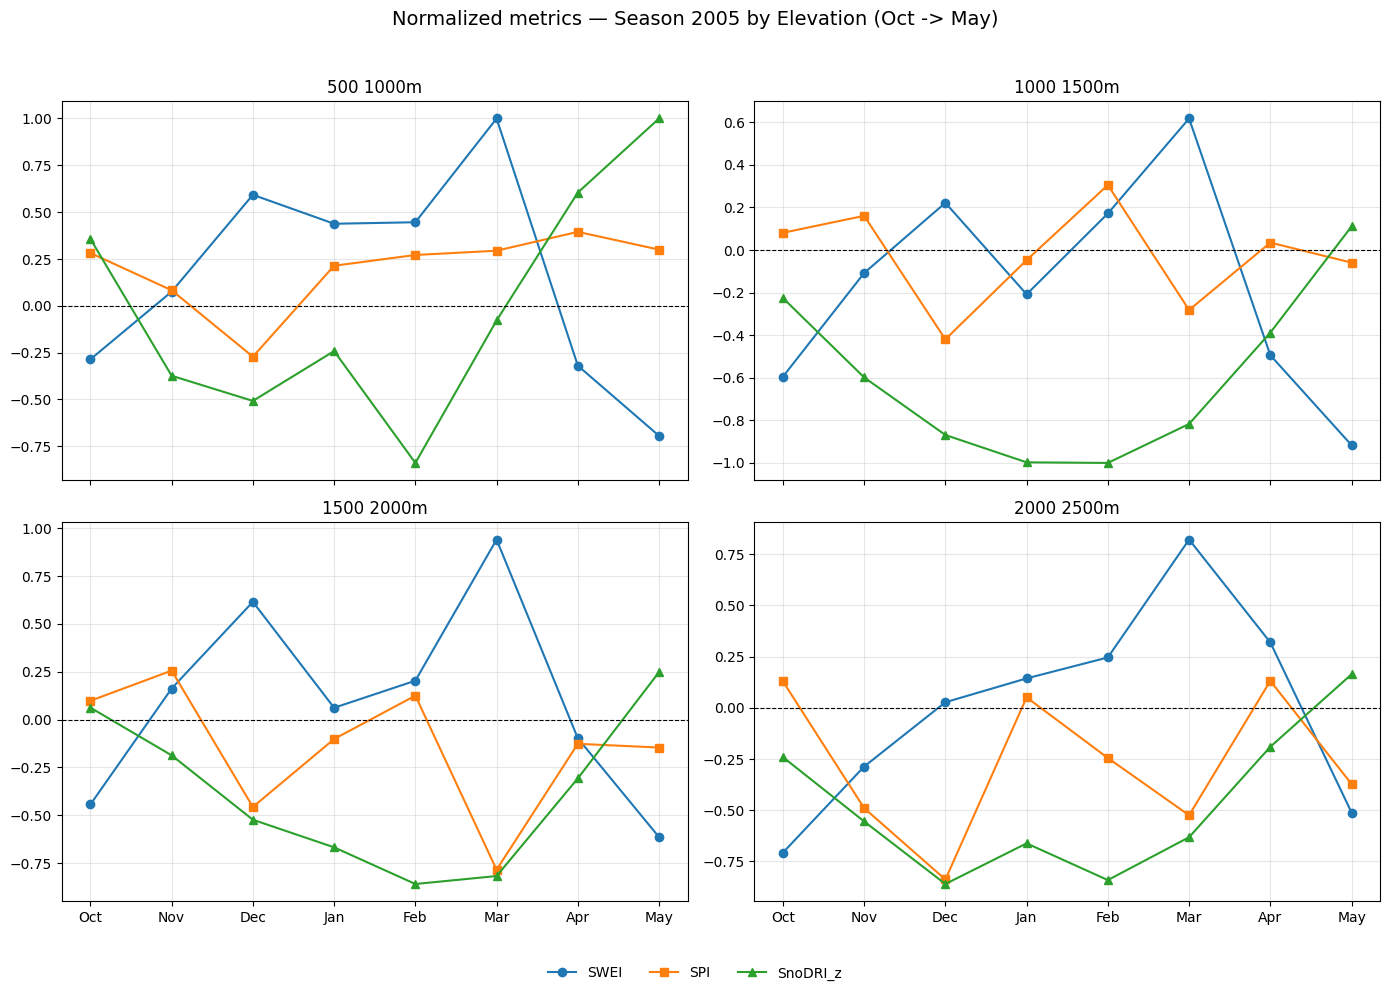

In [96]:
# Plot merged_2005_norm: 4 subplots (one per elevation) showing Oct->May
if 'merged_2005_norm' not in globals():
    raise NameError("merged_2005_norm not found. Run the cell that creates it first.")

month_order = [10, 11, 12, 1, 2, 3, 4, 5]
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
elev_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

color_map = {'SWEI': '#1f77b4', 'SPI': '#ff7f0e', 'SnoDRI_z': '#2ca02c'}
marker_map = {'SWEI': 'o', 'SPI': 's', 'SnoDRI_z': '^'}

def fetch_series(df, elev, metric):
    # try wide column names first (e.g. "1000_1500m_SPI" or "1000_1500m_SPI_norm")
    wide_candidates = [
        f"{elev}_{metric}",
        f"{elev}_{metric}_norm",
        f"{elev}_{metric.replace('SnoDRI_z','SnoDRI')}",  # tolerant fallback
    ]
    for c in wide_candidates:
        if c in df.columns:
            return df.set_index('month').reindex(month_order)[c].values

    # otherwise try long form: filter by Elevation_Category and use metric (or metric_norm)
    if 'Elevation_Category' in df.columns:
        sub = df[df['Elevation_Category'] == elev].set_index('month').reindex(month_order)
        for c in [f"{metric}_norm", metric]:
            if c in sub.columns:
                return sub[c].values
    # not found -> return array of NaNs
    return np.full(len(month_order), np.nan)

for ax, elev in zip(axes, elev_order):
    plotted = False
    for metric in ['SWEI', 'SPI', 'SnoDRI_z']:
        y = fetch_series(merged_2005_norm, elev, metric)
        if not np.all(np.isnan(y)):
            ax.plot(month_labels, y, marker=marker_map.get(metric, 'o'),
                    label=metric, color=color_map.get(metric, None), lw=1.5)
            plotted = True
    if not plotted:
        ax.text(0.5, 0.5, f'No data for {elev}', transform=ax.transAxes, ha='center', va='center')
    ax.set_title(elev.replace('_', ' '))
    ax.axhline(0, color='k', lw=0.8, linestyle='--')
    ax.grid(alpha=0.3)

# hide any unused axes
for j in range(len(elev_order), len(axes)):
    axes[j].set_visible(False)

# global legend
handles, labels = [], []
for a in axes:
    h, l = a.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll not in labels:
            handles.append(hh); labels.append(ll)
if handles:
    fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False)

fig.suptitle('Normalized metrics — Season 2005 by Elevation (Oct -> May)', fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])
out_file = config['plots'] / 'merged_2005_by_elevation_oct_may.png'
fig.savefig(out_file, dpi=150)
print(f"Saved figure to: {out_file}")
plt.show()

In [ ]:
import calendar

# Merge SSWEI, SPI and SnoDRI on Season_year, Elevation_Category and month; keep only relevant columns.


# copies to avoid modifying originals
swei = swei_2005.copy()
spi = spi_2005.copy()
snodri = snodri_2005.copy()

# ensure month exists in snodri (extract from month_end if necessary)
if 'month' not in snodri.columns:
    if 'month_end' in snodri.columns:
        snodri['month'] = pd.to_datetime(snodri['month_end'], errors='coerce').dt.month
    else:
        # try to infer from any date-like column
        for c in snodri.columns:
            if snodri[c].dtype == object:
                parsed = pd.to_datetime(snodri[c], errors='coerce')
                if parsed.notna().sum() > 0:
                    snodri['month'] = parsed.dt.month
                    break

# select minimal columns to merge / keep
swei_sel = swei[['Season_year', 'Elevation_Category', 'month', 'month_label', 'SSWEI']].copy()
spi_sel = spi[['Season_year', 'Elevation_Category', 'month', 'Precipitation', 'SPI']].copy()
snodri_sel = snodri[['Season_year', 'Elevation_Category', 'month', 'SnoDRI', 'SnoDRI_z']].copy()

# perform merges (outer to retain any rows present in any source)
merged = pd.merge(swei_sel, spi_sel, on=['Season_year', 'Elevation_Category', 'month'], how='outer', validate='1:1', suffixes=('_swei', '_spi'))
merged = pd.merge(merged, snodri_sel, on=['Season_year', 'Elevation_Category', 'month'], how='outer', validate='1:1')

# ensure there is a month_label (prefer existing, else create from month)
if 'month_label' not in merged.columns or merged['month_label'].isna().any():
    merged['month_label'] = merged['month'].apply(lambda m: calendar.month_abbr[int(m)] if pd.notna(m) else np.nan)

# drop any remaining unnecessary raw columns if present
drop_candidates = [
    'month_end', 'time', 'Mean_Temp', 'Max_Temp', 'Humidity', 'snow_fraction',
    'Flux', 'Vwind', 'spi3', 'spi4', 'spi6', 'Precipitation_z', 'Mean_Temp_z',
    'Humidity_z', 'snow_fraction_z', 'Flux_z', 'Vwind_z', 'spi3_z', 'spi4_z', 'spi6_z','SnoDRI','Precipitation'
]
to_drop = [c for c in drop_candidates if c in merged.columns]
if to_drop:
    merged = merged.drop(columns=to_drop)

# reorder columns for readability
cols_order = ['Season_year', 'month', 'month_label', 'Elevation_Category', 'SSWEI', 'SPI', 'Precipitation', 'SnoDRI', 'SnoDRI_z']
final_cols = [c for c in cols_order if c in merged.columns] + [c for c in merged.columns if c not in cols_order]
merged = merged[final_cols]

# save merged result
out_file = config['output_dir'] / 'merged_by_elevation_month_2005.csv'
merged.to_csv(out_file, index=False)

print(f"Merged {len(merged)} rows; saved to {out_file}")
display(merged.head())

NameError: name 'swei_2005' is not defined

In [ ]:
# Unstack `merged` dataframe so each Elevation_Category becomes columns (wide format)
if 'merged' not in globals():
    raise NameError("merged dataframe not found. Run the merge cell (cell 42) first.")

# choose index and metric columns
index_cols = ['Season_year', 'month', 'month_label']
if not all(c in merged.columns for c in index_cols + ['Elevation_Category']):
    raise KeyError("merged is missing required columns (Season_year, month, month_label, Elevation_Category)")

metric_cols = [c for c in merged.columns if c not in index_cols + ['Elevation_Category']]
if not metric_cols:
    raise ValueError("No metric columns found to unstack in merged dataframe")

# pivot to wide: metrics x elevation -> columns will be MultiIndex (metric, Elevation_Category)
merged_wide = merged.pivot_table(index=index_cols, columns='Elevation_Category', values=metric_cols, aggfunc='first')

# flatten MultiIndex columns to 'metric_elevation' naming
if isinstance(merged_wide.columns, pd.MultiIndex):
    merged_wide.columns = [f"{metric}_{elev}" for metric, elev in merged_wide.columns]
else:
    # single metric case: columns are elevation categories -> prefix with metric name
    merged_wide.columns = [f"{metric_cols[0]}_{c}" for c in merged_wide.columns]

# reset index to turn Season_year/month back into columns
merged_unstacked = merged_wide.reset_index().sort_values(index_cols).reset_index(drop=True)

# save and display
out_file = config['output_dir'] / 'merged_unstacked_by_elevation.csv'
merged_unstacked.to_csv(out_file, index=False)
print(f"Saved unstacked merged dataframe to: {out_file}")
display(merged_unstacked.head())

Saved unstacked merged dataframe to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\merged_unstacked_by_elevation.csv


Season_year  month month_label  SPI_1000_1500m  SPI_1500_2000m  \
0         2005      1         Jan       -0.349224       -0.382049   
1         2005      2         Feb        0.466405        0.035853   
2         2005      3         Mar       -0.891061       -1.640496   
3         2005      4         Apr       -0.159193       -0.427991   
4         2005      5         May       -0.376534       -0.464000   

   SPI_2000_2500m  SPI_500_1000m  SSWEI_1000_1500m  SSWEI_1500_2000m  \
0        0.390312       0.233379         -0.971672         -1.459747   
1       -0.213536       0.368217          0.817519         -0.370931   
2       -0.784207       0.422021         -0.546499         -0.647179   
3        0.554801       0.658789         -1.214669         -1.331006   
4       -0.473230       0.435772         -1.179104         -0.118738   

   SSWEI_2000_2500m  SSWEI_500_1000m  SnoDRI_z_1000_1500m  \
0         -1.290024        -1.073578            -0.530610   
1         -1.383112         0.032467            -1.257527   
2         -1.527944        -0.998264            -1.086706   
3         -1.539571        -1.350008            -0.179885   
4         -0.176703        -1.473794             0.660790   

   SnoDRI_z_1500_2000m  SnoDRI_z_2000_2500m  SnoDRI_z_500_1000m  
0            -0.560962            -0.452359            0.360861  
1            -1.228690            -1.278078           -0.907150  
2            -1.364560            -1.290957           -0.449877  
3            -0.390661            -0.369682            0.733632  
4             0.512511             0.323887            1.531504

In [ ]:
if 'merged_unstacked' not in globals():
    raise NameError("merged_unstacked not found. Run the previous cells that create it first.")

merged_unstacked_norm = merged_unstacked.copy()
num_cols = merged_unstacked_norm.select_dtypes(include=[np.number]).columns.tolist()

for col in num_cols:
    s = pd.to_numeric(merged_unstacked_norm[col], errors='coerce')
    valid = s.notna()
    if not valid.any():
        merged_unstacked_norm[col] = np.nan
        continue
    mn = s[valid].min()
    mx = s[valid].max()
    if np.isclose(mx, mn):
        # constant column -> set to 0 for valid entries
        merged_unstacked_norm.loc[valid, col] = 0.0
    else:
        merged_unstacked_norm.loc[valid, col] = -1.0 + 2.0 * (s[valid] - mn) / (mx - mn)

# save normalized result
out_file = config['output_dir'] / 'merged_unstacked_normalized.csv'
merged_unstacked_norm.to_csv(out_file, index=False)
print(f"Normalized {len(num_cols)} numeric columns and saved to: {out_file}")

# show a preview
display(merged_unstacked_norm.head())

Normalized 14 numeric columns and saved to: c:\Users\walimunige.rupasingh\OneDrive - University of Calgary\Documents\GitHub\snowdroughtindex-main\data\output_data\1980_2024\comparison\merged_unstacked_normalized.csv


C:\Users\walimunige.rupasingh\AppData\Local\Temp\ipykernel_37196\2701836497.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.         -0.81818182 -0.63636364 -0.45454545 -0.27272727  0.63636364
  0.81818182  1.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  merged_unstacked_norm.loc[valid, col] = -1.0 + 2.0 * (s[valid] - mn) / (mx - mn)


Season_year     month month_label  SPI_1000_1500m  SPI_1500_2000m  \
0            0 -1.000000         Jan        0.026761        0.312858   
1            0 -0.818182         Feb        1.000000        0.748828   
2            0 -0.636364         Mar       -0.619779       -1.000000   
3            0 -0.454545         Apr        0.253513        0.264929   
4            0 -0.272727         May       -0.005826        0.227363   

   SPI_2000_2500m  SPI_500_1000m  SSWEI_1000_1500m  SSWEI_1500_2000m  \
0        0.833751       0.457015         -0.707386         -0.924902   
1        0.223440       0.629120          1.000000          0.429983   
2       -0.353338       0.697794         -0.301653          0.086230   
3        1.000000       1.000000         -0.939273         -0.764701   
4       -0.039033       0.715345         -0.905334          0.743804   

   SSWEI_2000_2500m  SSWEI_500_1000m  SnoDRI_z_1000_1500m  \
0         -0.633791        -0.468597            -0.639004   
1         -0.770397         1.000000            -1.000000   
2         -0.982938        -0.368596            -0.915168   
3         -1.000000        -0.835638            -0.464830   
4          1.000000        -1.000000            -0.047340   

   SnoDRI_z_1500_2000m  SnoDRI_z_2000_2500m  SnoDRI_z_500_1000m  
0            -0.595151            -0.562151           -0.432543  
1            -0.931549            -0.993276           -1.000000  
2            -1.000000            -1.000000           -0.795362  
3            -0.509354            -0.518984           -0.265722  
4            -0.054340            -0.156857            0.091340

In [97]:
# Plot monthly timeseries for 2005 using the merged (long) dataframe.
# merged_norm created earlier is wide and may not contain 'Elevation_Category' -> prefer the long `merged` produced in cell 42.
season = 2005
month_order = [10, 11, 12, 1, 2, 3, 4, 5]
month_labels = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May']
elev_order = ['500_1000m', '1000_1500m', '1500_2000m', '2000_2500m']

# Prefer the long merged dataframe which has Elevation_Category; fall back to merged_norm only if necessary.
if 'merged' in globals():
    merged_src = merged.copy()
elif 'merged_norm' in globals() and 'Elevation_Category' in merged_unstacked_norm.columns:
    merged_src = merged_unstacked_norm.copy()
else:
    raise NameError("No suitable merged dataframe found with 'Elevation_Category'. Run the merge cell (cell 42) first.")

merged_2005 = merged_src[merged_src['Season_year'] == season].copy()
if merged_2005.empty:
    raise ValueError(f"No rows for Season_year == {season} in merged dataframe")

# Ensure normalized columns exist for plotting. Create per-elevation normalization to [-1,1] if needed.
metrics = ['SSWEI', 'SPI', 'SnoDRI_z']
scaler = MinMaxScaler(feature_range=(-1, 1))
for metric in metrics:
    norm_col = f"{metric}_norm"
    # create column if missing
    if metric not in merged_2005.columns:
        merged_2005[norm_col] = np.nan
        continue
    if norm_col not in merged_2005.columns:
        merged_2005[norm_col] = np.nan

    for elev in merged_2005['Elevation_Category'].unique():
        mask = merged_2005['Elevation_Category'] == elev
        vals = merged_2005.loc[mask, metric].astype(float).values
        valid = ~np.isnan(vals)
        if valid.sum() == 0:
            merged_2005.loc[mask, norm_col] = np.nan
        elif valid.sum() == 1:
            merged_2005.loc[mask, norm_col] = 0.0
        else:
            try:
                scaled = np.full_like(vals, np.nan, dtype=float)
                scaled_valid = scaler.fit_transform(vals[valid].reshape(-1, 1)).ravel()
                scaled[valid] = scaled_valid
                merged_2005.loc[mask, norm_col] = scaled
            except Exception:
                s = pd.Series(vals)
                z = (s - s.mean()) / (s.std(ddof=0) if s.std(ddof=0) != 0 else 1.0)
                merged_2005.loc[mask, norm_col] = np.clip(z, -1, 1)

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True, sharey=False)
axes = axes.flatten()

for ax, elev in zip(axes, elev_order):
    df_e = (
        merged_2005[merged_2005['Elevation_Category'] == elev]
        .set_index('month')
        .reindex(month_order)
    )

    plotted = False
    if 'SSWEI_norm' in df_e.columns and df_e['SSWEI_norm'].notna().any():
        ax.plot(month_labels, df_e['SSWEI_norm'].values, marker='o', label='SSWEI', color='#1f77b4')
        plotted = True
    if 'SPI_norm' in df_e.columns and df_e['SPI_norm'].notna().any():
        ax.plot(month_labels, df_e['SPI_norm'].values, marker='s', label='SPI', color='#ff7f0e')
        plotted = True
    if 'SnoDRI_z_norm' in df_e.columns and df_e['SnoDRI_z_norm'].notna().any():
        ax.plot(month_labels, df_e['SnoDRI_z_norm'].values, marker='^', label='SnoDRI_z', color='#2ca02c')
        plotted = True

    if not plotted:
        ax.text(0.5, 0.5, f'No series for {elev}', transform=ax.transAxes, ha='center', va='center')

    ax.set_title(elev.replace('_', ' '))
    ax.axhline(0, color='k', lw=0.8, linestyle='--')
    ax.grid(alpha=0.3)

# global legend (gather from all axes)
handles = []
labels = []
for a in axes:
    h, l = a.get_legend_handles_labels()
    for hh, ll in zip(h, l):
        if ll not in labels:
            handles.append(hh); labels.append(ll)

fig.legend(handles, labels, loc='lower center', ncol=4, frameon=False)
fig.suptitle(f'Monthly timeseries — Season {season} by Elevation', fontsize=14)
plt.tight_layout(rect=[0, 0.05, 1, 0.96])

out_file = config['plots'] / f'merged_monthly_{season}_by_elevation.png'
fig.savefig(out_file, dpi=150)
print(f"Saved figure to: {out_file}")
plt.show()

NameError: No suitable merged dataframe found with 'Elevation_Category'. Run the merge cell (cell 42) first.